In [2]:
import xarray as xr
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from pathlib import Path
from matplotlib.colors import LogNorm
# from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset, inset_axes


In [146]:
ipralpath = Path('/bdd/SIRTA/pub/basesirta/1a/ipral/2020/11/29/ipral_1a_Lz1R15mF30sPbck_v01_20201129_000000_1440.nc')
ipralraw = xr.open_dataset(ipralpath)

In [4]:

ipralraw

<xarray.Dataset>
Dimensions:                (n_chan: 18, nv: 2, range: 4000, time: 1518)
Coordinates:
  * time                   (time) datetime64[ns] 2020-02-06T09:51:37 ... 2020...
  * range                  (range) float32 15.0 30.0 45.0 ... 5.998e+04 6e+04
Dimensions without coordinates: n_chan, nv
Data variables: (12/73)
    time_bnds              (time, nv) datetime64[ns] ...
    lat                    float32 ...
    lon                    float32 ...
    altitude               float32 ...
    wavelength             (n_chan) float32 ...
    telescope              (n_chan) int32 ...
    ...                     ...
    bckgrd_rcs_16          (time) float64 ...
    rcs_17                 (time, range) float64 ...
    bckgrd_rcs_17          (time) float64 ...
    time_resol             (time) float32 ...
    range_resol            float32 ...
    tilt_angle             float32 ...
Attributes: (12/73)
    system:                          CNRS/IPSL IPRAL RAMAN multiwavelength Lidar
    manufacturers:                   Gordien Strato, Raymetrics, Spectra physics
    overlap_is_corrected:            false
    overlap_function:                false
    site_location:                   Palaiseau, France
    instrument_id:                   IPRAL
    ...                              ...
    telescope0_type:                 Enhanced Cassegrain+Nasmith
    telescope0_manufacturer:         Gordien Strato
    telescope0_model:                special
    telescope1_type:                 Newton
    telescope1_manufacturer:         Gordien Strato
    telescope1_model:                special

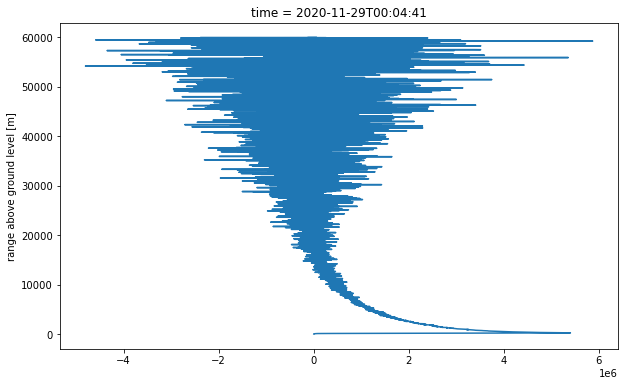

In [151]:
signal = ipralraw['rcs_12']
bckgrd = ipralraw['bckgrd_rcs_12']
ipralrange = ipralraw['range'].values
rcs = (signal/(ipralrange**2) - bckgrd)*(ipralrange**2)
fig, ax = plt.subplots(figsize=[10,6])
rcs.isel(time=10).plot(y='range', ax=ax)
# ax.set_ylim(0,14000)
# ax.set_xlim(dt.datetime(2020,2,6,0), dt.datetime(2020,2,7,0))
#ax.pcolormesh(ipralraw['rcs_16'].values.T, x=ipralraw['time'].values.astype('datetime64[ns]'), y=ipralraw['range'].values, robust=True, cmap='viridis')

/mnt/homedafs-2.5/lov/homedata/nmpnguyen/python_envs/ipral_tools/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/mnt/homedafs-2.5/lov/homedata/nmpnguyen/python_envs/ipral_tools/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


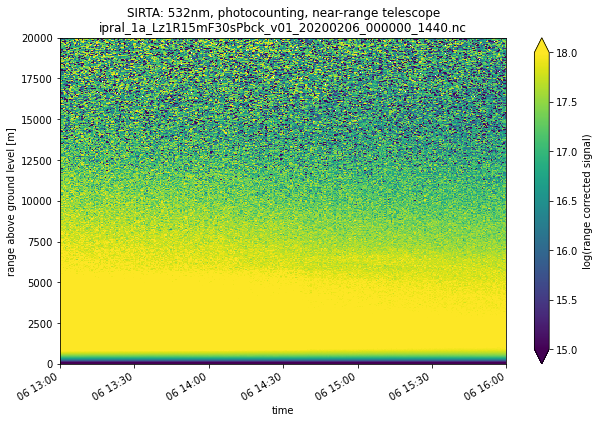

In [6]:

fig, ax = plt.subplots(figsize=[10,6])
np.log(rcs).plot(x = 'time', y='range', vmin=15, vmax=18, cbar_kwargs={"label": "log(range corrected signal)"}, robust=True)
ax.set_ylim(0,20000)
ax.set_xlim(dt.datetime(2020,2,6,13), dt.datetime(2020,2,6,16))
ax.set(title='SIRTA: 532nm, photocounting, near-range telescope\n'+ipralpath.name)
#print(rcs.isel(time=510))

#________AVERAGE________
rcsAV = rcs.resample(time='3H').mean()
#print(rcsAV.isel(time=1))


In [7]:
print(Path('/homedata/nmpnguyen/IPRAL/1a/').glob('ipral_1a_Lz1R15mF30sPbck_v01_202002*.pkl'))
ipralta = pd.read_pickle(sorted(Path('/homedata/nmpnguyen/IPRAL/1a/').glob('ipral_1a_Lz1R15mF30sPbck_v01_202002*.pkl'))[0])

<generator object Path.glob at 0x7f2dc4c8ecf0>


In [36]:
ta = ipralta['ta'].unstack(level=1).iloc[0,:]


In [63]:
from math import exp, log
def isa(alt):
    if alt <= 11000:
        pressure = 101325 * (1 - 2.2556e-5*alt)**5.25616
    else:
        pressure = 0.223356 * 101325 * exp(-0.000157688*(alt-11000))
    return pressure

def MolATB_from_PT(P,T,alt,w):
    const = (5.45e-32/1.38e-23)*(w*1e-3/0.55)**(-4.09)
    beta = const*(P/T).astype('float')
    alpha = beta/0.119
    tau = np.zeros_like(beta)
    for i in range(1, alt.shape[0]):
        tau[i] = tau[i-1] + alpha[i] * (alt[i] - alt[i-1])
        
    attenuation = beta*np.exp(-2*tau)
    return attenuation


def equiq_hydro(lat, alt):
    lat = np.deg2rad(lat)
    acc_gravity = 9.78032*(1+5.2885e-3*(np.sin(lat))**2 - 5.9e-6*(np.sin(2*lat))**2)
    r0 = 2*acc_gravity/(3.085462e-6 + 2.27e-9*np.cos(2*lat) - 2e-12*np.cos(4*lat))
    g0 = 9.80665
    #geopt_for_ipral['geopt_height'] = geopt_for_ipral["geopt"]/g0
    #geopt_for_ipral['altitude'] = (geopt_for_ipral['geopt_height']*r0)/(acc_gravity*r0/g0 - geopt_for_ipral['geopt_height'])
    M = 28.966E-3 
    R = 8.314510
    T = (15 + 273.15)
    const = -(M*g0)/(R*T)
    p0 = 101325
    pression = p0*np.exp(const*alt)
    return pression


In [64]:
# Calculer la pression
# Méthode 1: equilibre hydrostatique

iprallat = np.float(ipralraw['lat'])
pression1 = equiq_hydro(iprallat, ipralrange)

# Méthode 2: International Standard Atmosphere
pression2 = np.array([isa(z) for z in ipralrange])

(0.0, 25000.0)

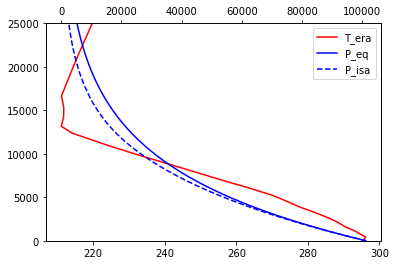

In [65]:
# plot temperature et pression
fig, ax = plt.subplots()
ax.plot(ta, ipralrange, color ='r', label='T_era')
ax2 = ax.twiny()
ax2.plot(pression1, ipralrange, color = 'b', label='P_eq')
ax2.plot(pression2, ipralrange, '--', color = 'b', label='P_isa')
line1, label1 = ax.get_legend_handles_labels()
line2, label2 = ax2.get_legend_handles_labels()
lines = line1 + line2
labels = label1 + label2
ax.legend(lines, labels, loc=0)
ax.set_ylim(0,25000)

In [66]:
# altitude référence
ipralrange_ref = (ipralrange>=4200) & (ipralrange<=4600)

# coef de calibration et Mol Attn Bsc
# Méthode 1: 
mol1 = MolATB_from_PT(pression1, np.array(ta), ipralrange, w=532)
coeff1 = np.nanmean(rcs[ipralrange_ref]/mol1[ipralrange_ref])

# Méthode 2:
mol2 = MolATB_from_PT(pression2, np.array(ta), ipralrange, w=532)
coeff2 = np.nanmean(rcs[ipralrange_ref]/mol2[ipralrange_ref])

(0.0, 25000.0)

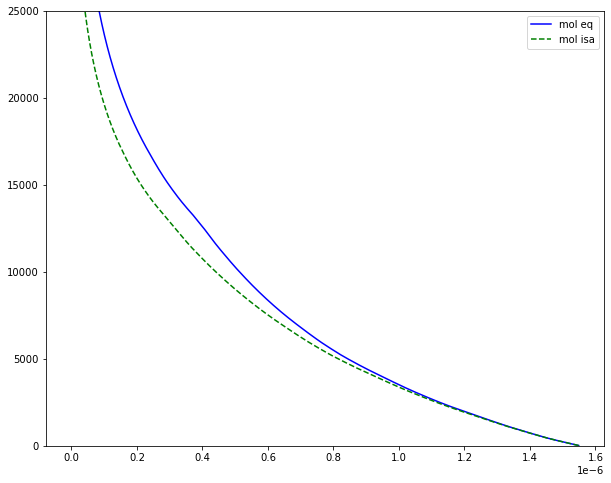

In [67]:
# plot 2 Molecular Attn Bsc
fig, ax = plt.subplots(figsize=[10,8])
ax.plot(mol1, ipralrange, color='b', label='mol eq')
ax.plot(mol2, ipralrange, '--', color='g', label='mol isa')
ax.legend(loc=0)
ax.set_ylim(0,25000)

In [68]:
print(coeff1, coeff2)

145812721226112.25 149794934927583.72


In [69]:
# Attn Bsc
# Methode 1:
attnbsc1 = rcs/coeff1
sr1 = attnbsc1/mol1
# Methode 2:
attnbsc2 = rcs/coeff2
sr2 = attnbsc2/mol2

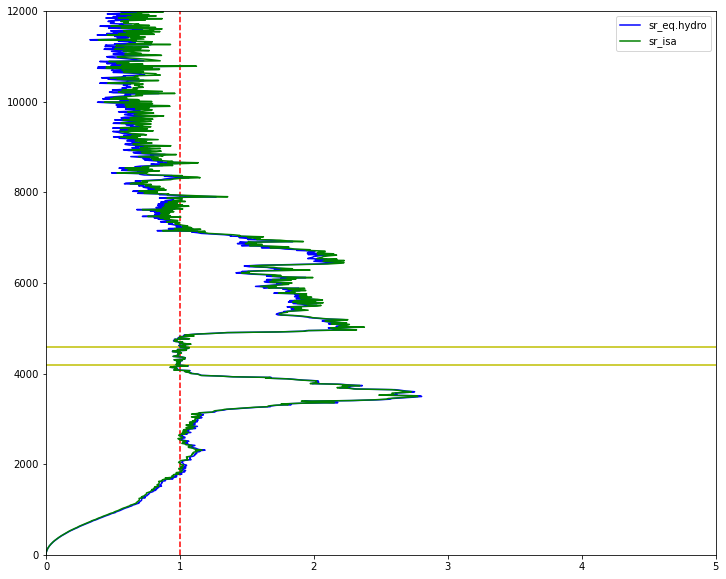

In [70]:
fig, ax = plt.subplots(figsize=[12,10])#, ncols=2, nrows=1)
#ax.plot(mol1, ipralrange, color='r', zorder=10)
#ax.plot(attnbsc1, ipralrange, color='b', label='mol eq')
ax.plot(sr1, ipralrange, label='sr_eq.hydro', color='b')
ax.hlines(ipralrange[ipralrange_ref][0], xmin=0, xmax=5, color='y')#mol1.min() mol1.max()
ax.hlines(ipralrange[ipralrange_ref][-1], xmin=0, xmax=5, color='y')
ax.vlines(1, ymin=0, ymax=ipralrange[-1], linestyle='--', color='r')
ax.legend()
ax.set_xlim(0, 5)
ax.set_ylim(0,12e3)

#ax2.plot(attnbsc2, oparalt+2160, '--', color='g', label='mol isa')
#ax2.plot(mol2, oparalt+2160, color='r', zorder=10)
ax.plot(attnbsc2/mol2, ipralrange, label='sr_isa', color='g')
#ax2.hlines(ipralrange[ipralrange_ref][0], xmin=0, xmax=5, color='y')
#ax2.hlines(ipralrange[ipralrange_ref][-1], xmin=0, xmax=5, color='y')
#ax2.vlines(1, ymin=0, ymax=ipralrange[-1], linestyle='--', color='r')
#ax2.legend()
#ax2.set_xlim(0, 5)
#ax2.set_ylim(0,12e3)
ax.legend()

In [37]:
import sys
sys.path.append('/home/nmpnguyen/')

In [38]:
from imp import reload as rl
import Attn_Bsc_theorie 
rl(Attn_Bsc_theorie)
from Attn_Bsc_theorie import Method1, Method2, Method3, Calibration


In [39]:
ipralraw = xr.open_dataset(Path('/bdd/SIRTA/pub/basesirta/1a/ipral/2020/02/06/ipral_1a_Lz1R15mF30sPbck_v01_20200206_000000_1440.nc'))

In [40]:
signal = ipralraw['rcs_17']
bckgrd = ipralraw['bckgrd_rcs_17']
ipralrange = ipralraw['range'].values
ipralalt = ipralrange + ipralrange[0]
print(signal.shape)
print(ipralalt)

(1518, 4000)
[3.0000e+01 4.5000e+01 6.0000e+01 ... 5.9985e+04 6.0000e+04 6.0015e+04]


In [41]:
ipralsimulpath = sorted(Path('/homedata/nmpnguyen/IPRAL/1a/').glob('ipral_1a_Lz1R15mF30sPbck_v01_202002*simul.pkl'))
print(ipralsimulpath)
ipralsimul = pd.read_pickle(ipralsimulpath[0])

[PosixPath('/homedata/nmpnguyen/IPRAL/1a/ipral_1a_Lz1R15mF30sPbck_v01_20200206_000000_1440_simul.pkl')]


In [42]:
#__Preparation Pression, Temperature et alt 
pression = ipralsimul['pression'].unstack(level=1)
ta = ipralsimul['ta'].unstack(level=1)


In [43]:
#______METHODE 1_________
idx = 520
opbetamol1 = Method1.computeMolATB_Calipso(P=pression.iloc[idx,:]*1e-2, T=ta.iloc[idx,:])
attnbetamol1 = Method1.computeAttnMolATB_Calipso(scat_vol=opbetamol1[0].values.astype('float'), 
                                                 beta_vol=opbetamol1[1].values.astype('float'), 
                                                 alt=ipralrange, 
                                                 datafrom='bottom')

In [44]:
opbetamol1[0].values.astype('float')

array([ 1.33706953e-03,  1.33547191e-03,  1.33387249e-03, ...,
       -7.37452771e-06, -7.38891421e-06, -7.40329940e-06])

In [45]:
#______METHODE 2_________
nd2 = Method2.compute_numb_density(P=pression.iloc[idx,:], T=ta.iloc[idx,:])
opextinction2 = Method2.computeMolExtinction(P=pression.iloc[idx,:]*1e-2, T=ta.iloc[idx,:], ND=nd2)
opbetamol2 = Method2.computeMolBackscatter(opextinction2)
attnbetamol2 = Method2.computeAttnMolBackscatter(alt=ipralrange, datafrom='bottom', 
                                                 extinction=opextinction2.values.astype('float'), 
                                                 beta_vol=opbetamol2.values.astype('float'))

In [46]:
#______METHODE 3_________
opbetamol3 = Method3.computeMolBackscatter(P = pression.iloc[idx,:], T= ta.iloc[idx,:], w=532)
attnbetamol3 = Method3.computeAttnMolBackscatter(alt=ipralrange, datafrom='bottom', 
                                                 extinction=opbetamol3[0].values.astype('float'), 
                                                 beta_vol=opbetamol3[1].values.astype('float'))

In [47]:
iprcs = (signal/(ipralrange**2) - bckgrd)*(ipralrange**2)
print(iprcs)

#________AVERAGE________
iprcsAV = rcs.resample(time='3H').mean()
print(iprcsAV.isel(time=1))


<xarray.DataArray (time: 1518, range: 4000)>
array([[ 2.84580313e+04,  1.17627908e+05,  2.90733835e+05, ...,
         4.33497816e+08,  1.14229492e+08,  1.54242253e+08],
       [ 2.85235962e+04,  1.18419579e+05,  2.90582234e+05, ...,
        -4.74373146e+08, -1.55125473e+08,  2.04397416e+08],
       [ 2.87558107e+04,  1.18249666e+05,  2.89368345e+05, ...,
         4.19507008e+06,  4.41327278e+07, -1.95578742e+08],
       ...,
       [ 2.82635847e+04,  1.15691415e+05,  2.91096461e+05, ...,
        -1.79800258e+05, -1.79890219e+05, -1.79980193e+05],
       [ 2.79339577e+04,  1.16760250e+05,  2.89927833e+05, ...,
        -5.99334215e+04, -5.99634086e+04, -5.99933999e+04],
       [ 2.78465526e+04,  1.16200852e+05,  2.90647006e+05, ...,
        -1.19866843e+05, -1.19926817e+05, -1.19986800e+05]])
Coordinates:
  * time     (time) datetime64[ns] 2020-02-06T09:51:37 ... 2020-02-06T23:59:05
  * range    (range) float32 15.0 30.0 45.0 60.0 ... 5.997e+04 5.998e+04 6e+04
<xarray.DataArray (range: 4

In [48]:
#______IPRAL RCS________

rcs1pf = iprcs.isel(time=idx)
rcsAV = iprcsAV.isel(time=1)

#______CONSTANCE DE CALIBRATION_______
zbottom=3000
ztop=3500
const1 = Calibration.ConstCalibration(zbottom, ztop, ipralrange, rcsAV, attnbetamol1)
print(const1)
const2 = Calibration.ConstCalibration(zbottom, ztop, ipralrange, rcsAV, attnbetamol2)
print(const2)
const3 = Calibration.ConstCalibration(zbottom, ztop, ipralrange, rcsAV, attnbetamol3)
print(const3)

const1pf = Calibration.ConstCalibration(zbottom, ztop, ipralrange, rcs1pf, attnbetamol1)
print(const1)
const2pf = Calibration.ConstCalibration(zbottom, ztop, ipralrange, rcs1pf, attnbetamol2)
print(const2)
const3pf = Calibration.ConstCalibration(zbottom, ztop, ipralrange, rcs1pf, attnbetamol3)
print(const3)

1213218445053797.2
3.936864471514377e+275
82459228887451.58
1213218445053797.2
3.936864471514377e+275
82459228887451.58


(0.0, 20000.0)

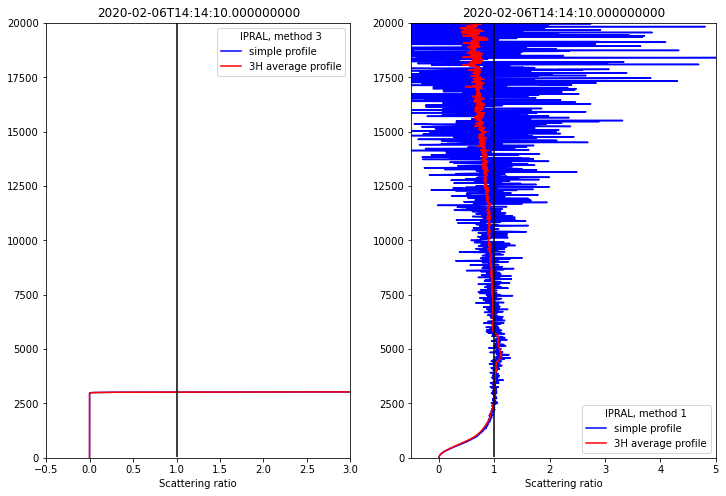

In [49]:
#______PLOTS_________
fig, (ax,ax2) = plt.subplots(ncols=2, nrows=1, figsize=[12,8])
ax.plot((rcs1pf/const2pf)/attnbetamol2, ipralrange, label='simple profile', color='b')
ax.plot((rcsAV/const2)/attnbetamol2, ipralrange, label='3H average profile', color='r')
ax.vlines(1, ymin=ipralrange.min(), ymax=ipralrange.max(), color='k', zorder=10)
ax.set(xlabel='Scattering ratio')
leg = ax.legend()
leg.set_title('IPRAL, method 3')
ax.set(title=str(iprcs['time'][idx].values))
ax.set_xlim(-0.5,3)
ax.set_ylim(0,20000)
#ax2.plot((rcs/const3)/attnbetamol3, ipralrange, label='methode2')
#ax2.plot((rcs/const2)/attnbetamol2, ipralrange, label='methode3')
ax2.plot((rcs1pf/const3pf)/attnbetamol3, ipralrange, label='simple profile', color='b')
ax2.plot((rcsAV/const3)/attnbetamol3, ipralrange, label='3H average profile', color='r')
ax2.vlines(1, ymin=ipralrange.min(), ymax=ipralrange.max(), color='k', zorder=10)
ax2.set(xlabel='Scattering ratio')
leg2 = ax2.legend()
leg2.set_title('IPRAL, method 1')
ax2.set(title=str(iprcs['time'][idx].values))
ax2.set_xlim(-0.5,5)
ax2.set_ylim(0,20000)

(0.0, 20000.0)

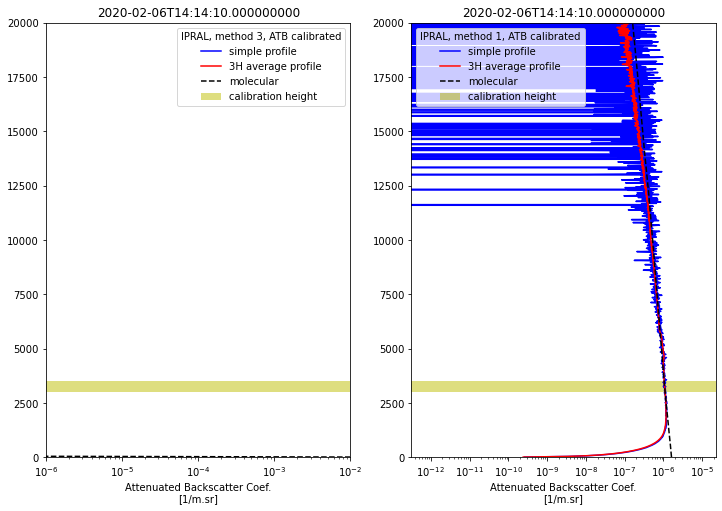

In [51]:
#______PLOTS_________ATB________ATB MOL_______
fig, (ax,ax2) = plt.subplots(ncols=2, nrows=1, figsize=[12,8])
ax.semilogx((rcs1pf/const2pf), ipralrange, label='simple profile', color='b')
ax.semilogx((rcsAV/const2), ipralrange, label='3H average profile', color='r')
ax.semilogx(attnbetamol2, ipralrange, '--', color='k', zorder=10, label='molecular')
ax.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax.set(xlabel='Attenuated Backscatter Coef.\n[1/m.sr]')
leg = ax.legend()
leg.set_title('IPRAL, method 3, ATB calibrated')
ax.set(title=str(iprcs['time'][idx].values))
ax.set_ylim(0, 20000)
ax.set_xlim(1e-6, 1e-2)

#ax2.plot((rcs1pf/const3)/attnbetamol3, ipralrange, label='methode2')
#ax2.plot((rcs1pf/const2)/attnbetamol2, ipralrange, label='methode3')
ax2.semilogx((rcs1pf/const3pf), ipralrange, label='simple profile', color='b')
ax2.semilogx((rcsAV/const3), ipralrange, label='3H average profile', color='r')
ax2.semilogx(attnbetamol3, ipralrange, '--', color='k', zorder=10, label='molecular')
ax2.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax2.set(xlabel='Attenuated Backscatter Coef.\n[1/m.sr]')
leg2 = ax2.legend()
leg2.set_title('IPRAL, method 1, ATB calibrated')
ax2.set(title=str(iprcs['time'][idx].values))
#ax2.set_xlim(1e-6, 1e-3)
ax2.set_ylim(0, 20000)

## Using SCC tools
__Objectif: Utiliser les produits de SCC pour obtenir une calibration plus efficace__

Prendre un des sous-répertoires qui contiennent des hirelpp, elda, elic...
Exemple de sous-répertoire du jour 20200708sir8018

In [106]:
scc_output_path = Path('/homedata/pietras/IPRAL/SCC/Input_auto/Output/Auto/377/20201129sir8208/')

# hirelpp_path = Path('/homedata/pietras/IPRAL/SCC/Input_auto/Output/Auto/375/20200708sir8018/hirelpp/sir_009_0000985_202007081800_202007081900_20200708sir8018_hirelpp_v5.2.1.nc')
elpp_path = sorted(Path(scc_output_path,'elpp').glob('*.nc'))#'/elpp/sir_000_0000975_202007081800_202007081900_20200708sir8018_elpp_v5.2.1.nc'
elic_path = sorted(Path(scc_output_path,'elic').glob('*.nc'))#'/elic/sir_000_0000975_202007081800_202007081900_20200708sir8018_elic_v5.2.1.nc'
elda_path = sorted(Path(scc_output_path,'elda').glob('*_0355_*.nc'))#sir_000_0532_0000975_202007081800_202007081900_20200708sir8018_elda_v5.2.1.nc')
print(elda_path[0])
print(elic_path[0])

/homedata/pietras/IPRAL/SCC/Input_auto/Output/Auto/377/20201129sir8208/elda/sir_000_0355_0000981_202011290800_202011290900_20201129sir8208_elda_v5.2.3.nc
/homedata/pietras/IPRAL/SCC/Input_auto/Output/Auto/377/20201129sir8208/elic/sir_000_0000981_202011290800_202011290900_20201129sir8208_elic_v5.2.3.nc


In [130]:
# scc_output_data = xr.open_dataset(scc_output_list[0])
hirelpp_data = xr.open_dataset(hirelpp_path[0])
elpp_data = xr.open_dataset(elpp_path[0])
elic_data = xr.open_dataset(elic_path[0])
elda_data = xr.open_dataset(elda_path[0])

NameError: name 'hirelpp_path' is not defined

In [143]:
print(elpp_data.variables)
# print(elic_data.variables)
# print(elda_data.variables)


Frozen({'latitude': <xarray.Variable ()>
array(2.2)
Attributes:
    standard_name:  latitude
    long_name:      measurement site latitude
    units:          degrees_north, 'longitude': <xarray.Variable ()>
array(48.7)
Attributes:
    standard_name:  longitude
    long_name:      measurement site longitude
    units:          degrees_east, 'station_altitude': <xarray.Variable ()>
array(156.)
Attributes:
    units:      m
    long_name:  station altitude above see level, 'scc_product_type': <xarray.Variable ()>
array(2.)
Attributes:
    units:          1
    long_name:      SCC product type
    valid_range:    [1 2]
    flag_values:    [1 2]
    flag_meanings:  experimental operational, 'altitude': <xarray.Variable (time: 4, level: 4000)>
array([[  163.5,   178.5,   193.5, ..., 60118.5, 60133.5, 60148.5],
       [  163.5,   178.5,   193.5, ..., 60118.5, 60133.5, 60148.5],
       [  163.5,   178.5,   193.5, ..., 60118.5, 60133.5, 60148.5],
       [  163.5,   178.5,   193.5, ..., 60118.5

In [144]:
# print(elpp_data['range_corrected_signal'])
print(elpp_data['altitude'])
# print(scc_output_data['time'])
# print(scc_output_data['channel'])

<xarray.DataArray 'altitude' (time: 4, level: 4000)>
array([[  163.5,   178.5,   193.5, ..., 60118.5, 60133.5, 60148.5],
       [  163.5,   178.5,   193.5, ..., 60118.5, 60133.5, 60148.5],
       [  163.5,   178.5,   193.5, ..., 60118.5, 60133.5, 60148.5],
       [  163.5,   178.5,   193.5, ..., 60118.5, 60133.5, 60148.5]])
Coordinates:
    altitude  (time, level) float64 163.5 178.5 193.5 ... 6.013e+04 6.015e+04
  * time      (time) datetime64[ns] 2020-11-29T08:00:17 ... 2020-11-29T08:45:43
Dimensions without coordinates: level
Attributes:
    units:          m
    standard_name:  altitude
    long_name:      altitude above see level


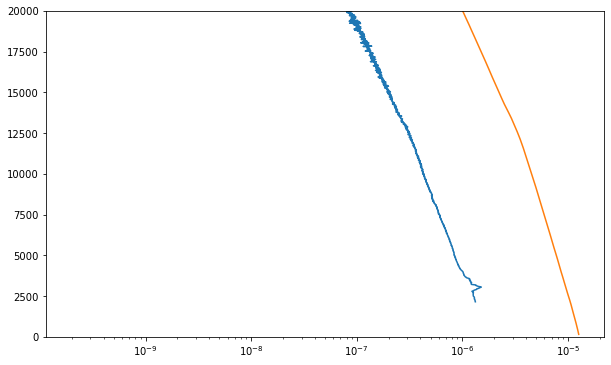

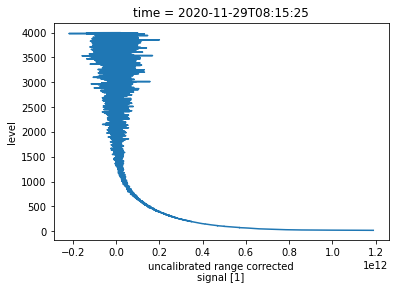

In [145]:
alt = scc_output_data['altitude'][1,:]
fig, ax = plt.subplots(figsize=[10,6])
ax.semilogx(scc_output_data['attenuated_backscatter'][1,1,:] , alt, label='attn_bsc')
ax.semilogx(scc_output_data['molecular_extinction'][1,1,:] , alt, label='bsc')
ax.set_ylim(0,20000)

fig, ax = plt.subplots()
elpp_data.isel(channel=0, time=1)['range_corrected_signal'].plot(y='level', ax=ax)
# elda_data.isel(wavelength=0, time=0)['backscatter'].plot(y='altitude', ax=ax)
# ax.set_xlim(0, 1e-5)

In [34]:
a = 1/scc_output_data['molecular_lidar_ratio'][1]
scc_attnbsc1pf = scc_output_data['attenuated_backscatter'][1,1,:] 
scc_molext1pf = scc_output_data['molecular_extinction'][1,1,:]data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAZIAAAEiCAYAAADTSFSPAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAAAziUlEQVR4nO3deZhcRb3/8fcnCwkJhDVgSAgBDGDCZY0YRBQFBRUFBTQIEhTNBbkX1OtCfirgknvdrgsiIMq+Iy7EqyCIICJLCAiEgGggAQYCCYIQtpCE7++PqiYnne6ezvT0TPfM5/U8/fQ5VafOqdM9c6pPVZ0qRQRmZmZdNaC3M2BmZu3NBYmZmTXEBYmZmTXEBYmZmTXEBYmZmTXEBYmZmTXEBUmdJI2V9Lykgb2dFzNrLkkh6fVdTHuYpGu6MS9HSrqpu/bXDC5IqpC0QNI+pfWIeCQi1omIFb2Zr2okDZF0lqSHJS2R9FdJ7y7bZm9Jf5P0oqTrJW1RiPu8pHtz2vmSPl+WdlxO82Lexz7UIOnrkuZIWi7p5LK4UZJmSno8/8OO62Rf75V0k6R/SXpC0k8lrVuIHy3pSklPS+qQdHQO3zMX/s9LeiEf6/nCa2z+3M6W9Fze92fLjv0OSXfm+IckTeskr5/J+3k273dIIW5DSb/KeXlY0kdq7GctSVfkv8OQtFeFbXaRdGM+lyclHV9jf5+QNC9ve7WkzQpx60s6T9Ki/Dq5LO2bJc3Kfxv3SHpLIU6SviTpkfwZXSppRCG+4ndTiH9f/rt7XtLNkiYU4s4o+76WSlpS4dzGS3pZ0oVVzv2k/BnW/Jvtivx/EZIGlcIi4qKIeFdhmy4XSm0jIvyq8AIWAPv0dj7WIL/DgZOBcaQfCPsDS4BxOX5j4FngEGAo8B3g1kL6LwC7AIOAbYGHgSmF+FuA7wFrAwcB/wJG1sjPVODdwJXAyWVxmwKfAnYHopTHGvv6CLAfMAzYALgKOKMQfz3wA2AwsCPwNPD2sn2My8caVBb+P8Cf837fADwB7JfjBufP7N8BAW8Engd2rJLPfYEngYl5fzcA3yzEXwJcBqwDvCXve2KVfa0FfDpvtxDYqyx+Y2ARcBgwBFgXeEOVfb0tbzsx7/d04E+F+HOAn+fPdxzwIPCxHLch8FT+uxkIHA48A2xQ+J7/Bmyez+tK4Lx6vhtgPPBcPsdBwHRgXvl3VNjXucDZFcKvyd/hhRXitgbmAI+zBv/P+W/l9XVsV/Hvqiv7qpH+SOCm7rxedPer1zPQii/gAuBV4KV84fhC+R9Mvkh8A7g5b/MbYCPgovzPcTuFCySwHXBt/kd6APhQD5zHPcBBeXkacHMhbng+v+2qpD0F+FFe3gZYCqxbiP8zcHQdebiQsoKkEDeIOgqSCuk+CMzJy+vkfYwsxJ8JXFCWpuI/PPAY8K7C+teBS/PypjnNsEL87cChVfJ1MfDfhfW9gScKn/crwDZlf2ffrON8O1i9IPnv8nOskf67wI8L65vl89o6rz8FvLEQ//+AP+fl/YG5Zfv7O3BUXr4C+Hwh7s3Ay6RCqeZ3A/wH8NtC3ID8N7l3hXMYTvph9Lay8CnA5aQfUZUKkquA97CGPwwpXPyB9wJ/Jf1fP1r8ewYeyds+n1+7U7jwAzfm+Bdy/IepUDCUHW8jYGY+3qz8N3lTYdsev5Z09nLVVgUR8VHSH8j7IlVnfbvKplOAjwKjSb98biH9utsQuB84CUDScNIXfzGwCXAocJqkiZV2Kum0XI1T6XVPPecgaVNSATA3B00E7i6c4wukX56r5UGSgD3L0j4UEcVqhbsrpe0hb2Vl3lT2XlrevrOdSNqAdFG9uxD82nlFxJOku4iPSRooaXdgC+CmnP4tkv5VSDuxwr42lbQR6btYERF/r3SsvL9/FauNOjEZeDpXBy2S9BtJY6udKqt/PrDqZ1Tt8ytP21m8SHdI4+n8u6mUttp3dxCwmHRhThunKrSvAf9VYXskHQK8EhG/qxS/Bl4AjgDWJxUqx0g6MMe9Nb+vn68VtxQTRkQpfsccf1kdx/sxqTAeBXw8v4A1v5b0FBckjTknIh6MiGdJv3wejIg/RMRyUlXBznm7/YEFEXFORCyPiDuBXwAHV9ppRHwqItav8tqhs0xJGky6MzovIv6Wg9chVaUUPUuqEil3Mulv45wupG0qSe8kVaecCJALt78AX5E0VNIupIvOsDp2t05+L55b+Xldko+1lHQX9qWIeDQf+6aIWL9sf+X7Iu+v088wf7/1NqqOIX0OxwNjgfk5r5X8DviQpB0krZ3PJ1j5GV0NnCBp3VyX//FC3M3AZpIOlTRY0lTSj6ZS/FXAJ3JbwXrAF3P4sDq+m2uBt0naS9JapDuhtaj83U0Fzo/8kzz7OnBW6fsokrQO6a7t01U+k7pFxA0RMSciXo2Ie0if89sa3W8lSp15DgJOjIgXIuJe4LzCJmt0LekpLkga82Rh+aUK66UL1RbAm4p3FqS67dd1d4YkDSBVmbxCqjooeR4YUbb5CFJ1QTH9f5B+fb03IpbWk1bS3EKD6J4N5r/YQD63LG4y6ZfYwWW/7A8DtiRVO5xOKkQ76jjc84VzobBcOq/tSG0aR5AucBOBL0h6b439le+LvL+6Pv818BLwq4i4PSJeBr4KvDlfzFcREdeR7o5/QWr7WpCPW/qMjsv7+wepjeOSUlxE/BM4APgs6e97P+APhbRn5+1vIN0lXp/DS/FVv5v8I2cqcCqpHWhj4D7KvjtJm5Mu3OcXwnYC9gG+X+Xz+SqpCm1+lfi6SXqTUkeTxZKeBY7OeW2GkaQq32Lh+HBhuceuJWvCBUl10fkmdXuU1LhZvLNYJyKOqbRxhd4qz1e7uJalE3AWqW7/oIhYVoieS2rsLG07nPTLcm4h7OPACaQ66o6ytFup0FMq72suQERMzOezTkT8ub6PpLKI+HNhX8Vqn51J9cYfzxfGYpqHI2L/iBgZEW8i1THPquNYz5AuYDsWgl87L1IVywMR8fv8a/QB4LekTgSVrPIZ5+Un88X478AgSeOrHGtN3cOqf6Ol5fJqqBQZ8eOIGB8Rm5AKlEHAvTnu6Yg4LCJelz/zARQ+v4j4U0S8MSI2JFXlbluKz5/LSRExLiLG5PN5LL86/W4i4oqI2D4iNiIVdluQ2qGKjiC17z1UCNuL1O71iKQngM8BB0m6M8fvDRyn1IPuCVJngMslfZE1dzHpb2/ziFgPOIOVn3NXrhMvULjrklQsBBYDy3N+S4pVlmt0LekxXWlY6Q8v4FZgWmF9HKs3tn+iEP8N4NzC+j7AvLy8LulXxUdJvVcGk3oAVexl00Cez8j5XqdC3EhSVcpBpF5b32LVXluHkXosVev5cyup0XYo8AE677U1OG97cf5shgIDC/FDSQ2oQbowDa2xr+1Jv4Y/XCX+DfkzXovUq+ip8ryVf3+F8G8CfyL1stqOVLCUem1tTbqTeAfpwrE1qVfRJ6vkY7/8GU7I+/sjq/baupT06304sAc1em3l7Yfkz6kDeFdeVo57B6n31E75s/4+uYG8wn6G5s9QpIvSDazaKWBr0gV+IKmQfKqYL1IV7WDSHdQPgL8U4jbM6ZXP+15W/b+p+d0Au+bjjiTd/V1cIf8PkH5AFMOGkX6Fl17fJTX8j8zxG5XFP0rqebZOjj+SVEVU7bMvNn4vAqbm5d3y+oWFfKxg1U4UR7Jq4/gTrNqho9R5Zaf83ZxRdrzL8t/KsPyZdrCy8b5HriVrfO3pzYO38ot0O/8I6YL5ORooSPL6tqRfs4uBf5IuMjt1Y363yPl7mZU9SJ4HDivL099I1Rg3sGqvsvnAsrK0xS6243Kal/I/ds0eMKSumlH2OrIQXx4XNfZ1DqkXXTFvcwvxn86f6wukhvBJFfaxyvdXCB9Cqp55jlRYfbYs/kOki2OpKuhbwIActyfwfNn2pSqg53K+hxTiNgR+nfP5CPCRsrTPA3sW1hdU+JyK39kxpF/+z5B6DW5eiJtb+u5JjcT35OM+QeryPLDsHB8HXgTuAvYty9clpELvWdJFbpNC3Db57+FF0gWu/POr+d3ksCWkHkg/AYaXxe+e065bDK/w/Z5MhV5bZZ/lPoX1rwAX1di+eGE/OJ/bEuD/SFVxFxa2/Vo+x3+ROkEcyaoFydGkHyj/IvewAr5EKlQfJRWwxeONzMep1mur7msJqZAq/h8X/y7G5r+5sY1ef0q/bszM+g2lJ8+Pj4j7ezsvfYELEjMza4gb283MrCEuSMzMrCEuSMzMrCEuSMzMrCGDOt+kb9l4441j3LhxvZ0NM7O2cscddzwVESMrxfW7gmTcuHHMnj27t7NhZtZWJD1cLc5VW2Zm1hAXJGZm1hAXJGZm1hAXJGZm1hAXJGZm1hAXJGZm1pCmFSSSzs5zSd9bFv6fkh7Is+p9uxA+XdK8HLdvIXxXSXNy3Cl58iYkDZF0WQ6/TdK4Zp2LmVlvennZCh7/10u8vGxFb2elomY+R3Iuadz+4vSYbyfN87FDRCyVtEkOnwBMIU1luhnwB0nbRMQK0vSc00gTK/2ONHnQVcBRwDMR8XpJU0jzRHy4iefDzQ8+xbMvLut8Q6ubBJUGoG7FcFg9rt3CWzFPjZ5Ds8OLqo2VXmsQ9aiSak2OMXvB05x/S9XHOOoybqNh/PJTe7Dh8LUa2k8lTStIIuLGCncJx5BmjFuat1mUww8ALs3h8yXNA3aTtAAYERG3AEg6HziQVJAcQJrMBtLMaKdKUjRpXPyr732Coy+8oxm7NjNrugX/fJFHnn6xvQqSKrYB9pQ0gzST3+ci4nZgNOmOo6Qjhy3Ly+Xh5PdHASJiuaRnSdNrPlV+UEnTSHc1jB07tjy6Lm/fbiRHvWVLHnvmpS6lb4bSLx2VTdPdbuHlca0cXoxr1/BSXKuF94VzqHb30Qz3L1zCI0+/uFr45/fdlo/uvgWDBwxg0EAxaICQVGEP3aenC5JBpLmsJ5PmGb5c0lZApbOMGuF0ErdqYMSZwJkAkyZN6tI3PWTQQL6y/4SuJDUz63Y7nPz715a/uN927POGTRg0cABbbjy8x/PS0wVJB/DLXP00S9KrwMY5fPPCdmNIc0h35OXycAppOiQNAtYjzftsZtanRQTPvbyc0euvzY1feDsDBzT3jqMzPd3999fAOwAkbQOsRaqKmglMyT2xtgTGA7MiYiGwRNLk3FvrCODKvK+ZwNS8fDDwx2a1j5iZtZohgwbw7u1f1+uFCDTxjkTSJcBewMaSOoCTgLOBs3OX4FeAqfniP1fS5cB9wHLg2NxjC1ID/bnA2qRG9qty+FnABblh/mlSry8zsz5vydLlLF3+KpuOGNrbWQGa22vr0CpRh1fZfgYwo0L4bGD7CuEvA4c0kkczs3Y0KN+FvPhKazxX4ifbzczazPJXI7+/2ss5SVyQmJm1mdJjCOM3XbeXc5K4IDEzazMvvrIcgPXWHtzLOUlckJiZtZl1h6YC5NmXWmPIJhckZmZtZu3BAwF42Y3tZmbWFc+8+AoA6w9z1ZaZmXXBitxra/Cg1riEt0YuzMysbstWpIJkUAs81Q4uSMzM2k5pMN/yEbV7iwsSM7M2U7oTWeYHEs3MrCsGDUiX7hUrWmOcWhckZmZtpjTib2molN7mgsTMrM0MGlgqSFy1ZWZmXVBqI1nuqi0zM+uK1+Ybb41OWy5IzMzazbIVqUqr1Oje25qWC0lnS1qUZ0Msj/ucpJC0cSFsuqR5kh6QtG8hfFdJc3LcKXnKXfK0vJfl8NskjWvWuZiZtZJXlqeCZOjgPl6QkKbH3a88UNLmwDuBRwphE0hT5U7MaU6TNDBHnw5MI83jPr6wz6OAZyLi9cD3gW815SzMzFrMa3ckA/t4QRIRN5LmUi/3feALrKzmAzgAuDQilkbEfGAesJukUcCIiLglz+1+PnBgIc15efkKYO/S3YqZWd+WLnXpstj7erQ4k/R+4LGIuLssajTwaGG9I4eNzsvl4aukiYjlwLPARlWOO03SbEmzFy9e3PB5mJm1glb57dxjBYmkYcCXgBMrRVcIixrhtdKsHhhxZkRMiohJI0eOrCe7ZmZWp568I9ka2BK4W9ICYAxwp6TXke40Ni9sOwZ4PIePqRBOMY2kQcB6VK5KMzOzJuqxgiQi5kTEJhExLiLGkQqCXSLiCWAmMCX3xNqS1Kg+KyIWAkskTc7tH0cAV+ZdzgSm5uWDgT9Gq1QYmpk1VWtd6prZ/fcS4BZgW0kdko6qtm1EzAUuB+4DrgaOjYjSHJLHAD8jNcA/CFyVw88CNpI0D/gscEJTTsTMrEW1RgsJDGrWjiPi0E7ix5WtzwBmVNhuNrB9hfCXgUMay6WZmTWqNTohm5lZ23JBYmbWZlqtNbhq1Zak5zpJK2BhRGzTvVkyM7N6tMhjJDXbSB6MiJ1rJZb0127Oj5mZtZlaVVsH1ZG+nm3MzKwPq3pHEhEPFdcljShuHxFPl29jZmbN12JNJJ13/5X078DXgJdYmf8AtmpivszMrBNqkSdJ6nmO5HPAxIh4qtmZMTOz9lNP998HgRebnREzM2tP9dyRTAdulnQbsLQUGBHHNS1XZmZWVds8R1LwE+CPwBzg1eZmx8zM6tUOz5GULI+IzzY9J2Zm1pbqaSO5Ps8wOErShqVX03NmZmZtoZ47ko/k9+mFMHf/NTPrJa/mRpIWqdnqvCCJiC17IiNmZlafUkEyYEBrFCVVq7Yk7dJZ4nq2MTOzbtZivbZqtZGcI2mDYrtI+Ys0S2FFks6WtEjSvYWw70j6m6R7JP1K0vqFuOmS5kl6QNK+hfBdJc3JcafkKXfJ0/JelsNvkzSukQ/CzKxd5Mvga3cmva1WQbIecEcnr2U10p8L7FcWdi2wfUTsAPyd3O4iaQIwBZiY05wmaWBOczowjTSP+/jCPo8CnomI1wPfB75V+1TNzPqGgblKq0XKkZqDNo5rZMcRcWP5XUJEXFNYvRU4OC8fAFwaEUuB+Xke9t0kLQBGRMQtAJLOBw4kzdt+AHByTn8FcKokRbTKR2tm1lytcrXrzRkSP04qEABGA48W4jpy2Oi8XB6+SpqIWA48C2zUxPyambWEFa+mEmRgqze2N5OkLwHLgYtKQRU2ixrhtdJUOt40SbMlzV68ePGaZtfMrKX0+4JE0lRgf+CwQjVUB7B5YbMxwOM5fEyF8FXSSBpEatN5utIxI+LMiJgUEZNGjhzZXadiZtYrlr+aRqtqlYKk1pztNbv2RsSda3owSfsBXwTeFhHFEYVnAhdL+h6wGalRfVZErJC0RNJk4DbgCOBHhTRTgVtIbS1/dPuImfUHpd5ag1q9IAH+t0ZcAO+otWNJlwB7ARtL6gBOIvXSGgJcm7uv3RoRR0fEXEmXA/eRqryOjYgVeVfHkHqArU1qUym1q5wFXJAb5p8m9foyM+vzlq9oraqtWr223t7IjiPi0ArBVZ87iYgZwIwK4bOB7SuEvwwc0kgezczaUemOpFUKkk7bSCQNk/RlSWfm9fGS9m9+1szMrJLc1s6AFhlHvp7G9nOAV4A35/UO4BtNy5GZmbWVegqSrSPi2+Sn2CPiJVpn0EkzM+tl9RQkr0ham/yMhqStKUy5a2ZmPavV+qfWMx/JycDVwOaSLgL2AI5sYp7MzKwOLdJEUtd8JNdIugOYTKrSOj4inmp6zszMrC10WpBImglcAsyMiBeanyUzM2sn9bSR/C+wJ3CfpJ9LOljS0Cbny8zMqogWm9mqnqqtPwF/yvODvAP4JHA2MKLJeTMzsxpapImkrsZ2cq+t9wEfBnYBzmtmpszMrH3U00ZyGfAmUs+tHwM3RMSrzc6YmZm1h3ruSM4BPlIYRNHMzHpRqz1HUk9j+43AdI+1ZWbWWlrlORKPtWVmZg3xWFtmZm2mxWq2PNaWmVn7ao3f9PUUJCex6lhb1wFf6CyRpLMlLZJ0byFsQ0nXSvpHft+gEDdd0jxJD0jatxC+q6Q5Oe4U5akVJQ2RdFkOv03SuPpP28zMukunBUlEXAt8kDRQ4yXApIi4oY59nwvsVxZ2AnBdRIwnFUgnAEiaQJoqd2JOc1p+ABLgdGAaaR738YV9HgU8ExGvB74PfKuOPJmZWTerWpBI2qX0ArYAFgKPA2NzWE0RcSNpLvWiA1j5MON5wIGF8EsjYmlEzAfmAbtJGgWMiIhbIiKA88vSlPZ1BbB36W7FzKwvixbr/1vrOZL/rREXpOFS1tSmEbEQICIWStokh48Gbi1s15HDluXl8vBSmkfzvpZLehbYCPDIxGbWL7TKT+eqBUlEvL0H81Hp44ga4bXSrL5zaRqpeoyxY8d2JX9mZlZFPY3t3enJXF1Ffl+UwzuAzQvbjSFVo3Xk5fLwVdJIGgSsx+pVaQBExJkRMSkiJo0cObKbTsXMzKDnC5KZwNS8PBW4shA+JffE2pLUqD4rV4MtkTQ5t38cUZamtK+DgT9Gq1Ucmpn1A3WN/tsVki4B9gI2ltRB6kb8TeBySUcBjwCHAETEXEmXA/cBy4FjC2N7HUPqAbY2cFV+AZwFXCBpHulOZEqzzsXMrBW1SBNJ3cPIb0C6S3htQqvcK6uqiDi0StTeVbafAcyoED4b2L5C+MvkgsjMzHpPPcPIfwI4ntQ+cRdp7vZb6FqvLTMz62PqaSM5Hngj8HDuybUzsLipuTIzs6parTW4noLk5VyNhKQhEfE3YNvmZsvMzDrTKs9g19NG0iFpfeDXwLWSnmFlF1wzM+vnOi1IIuIDefFkSdeTnte4uqm5MjOzqqLFBpKvt9fWW4DxEXGOpJGk4UnmNzVnZmZWU2tUbNXRRiLpJOCLwPQcNBi4sJmZMjOz9lFPY/sHgPcDLwBExOPAus3MlJmZtY+6ZkjMQ4+UZkgc3twsmZlZLe3Y/fdyST8B1pf0SeAPwE+bmy0zM+tMi/T+ravX1nclvRN4jvT8yIl51kQzM7O6hkgZThpZ91pJ2wLbShocEcuanz0zM2t19VRt3QgMkTSaVK31MdJovGZm1gvasY1EEfEi8EHgR/kBxQnNzZaZmXVGLfIkSV0FiaTdgcOA3+awps1jYmZm7aXe0X+nA7/KE1BtBVzf3GyZmVm7qKfX1o2kdpLS+kPAcc3MlJmZVddiTSQ9Pmc7AJI+I2mupHslXSJpqKQNJV0r6R/5fYPC9tMlzZP0gKR9C+G7SpqT405Rq4ypbGbWA1rlitfjBUnu/XUcMCkitgcGkuZbPwG4LiLGA9fldSRNyPETgf2A0yQNzLs7HZhGmgZ4fI43M7Me1Ct3JKQqtbUlDQKGkeY3OQA4L8efBxyYlw8ALo2IpRExH5gH7CZpFDAiIm7JQ7icX0hjZtZnRYv1/61n9N9tJF0n6d68voOkL3f1gBHxGPBd4BFgIfBsRFwDbBoRC/M2C4FNcpLRwKOFXXTksNF5uTy80jlMkzRb0uzFiz1LsJlZd6rnjuSnpF5bywAi4h5SVVOX5LaPA4Atgc2A4ZIOr5WkQljUCF89MOLMiJgUEZNGjhy5plk2M7Ma6ilIhkXErLKw5Q0ccx9gfkQszsOs/BJ4M/Bkrq4ivy/K23cAmxfSjyFVhXXk5fJwMzPrQfUUJE9J2pqVw8gfTKqS6qpHgMmShuVeVnsD9wMzgal5m6nAlXl5JjBF0hBJW5Ia1Wfl6q8lkibn/RxRSGNm1me1VgtJfU+oHwucCWwn6THSFLuHdfWAEXGbpCuAO0l3Nn/N+1+HNGT9UaTC5pC8/VxJlwP35e2PjYgVeXfHkMb9Whu4Kr/MzPqFVun+W09B8nBE7JNHAR4QEUsaPWhEnAScVBa8lHR3Umn7GcCMCuGzge0bzY+ZmXVdPVVb8yWdCUwGnm9yfszMrM3UU5BsSxo+/lhSoXKqpLc0N1tmZlZVizWSdFqQRMRLEXF5RHwQ2BkYAfyp6TkzM7OaWmVUqLqebJf0NkmnkRrIhwIfamquzMysbdQz1e584C7gcuDzEfFCszNlZmbto55eWztGxHNNz4mZmdUlWqyRpJ6qrRGSfiVpkaQnJf1C0pjOk5mZWTO1RgtJfQXJOaSnyzcjDYr4mxxmZmZWV0EyMiLOiYjl+XUu4JEPzcwMqH+srcMlDcyvw4F/NjtjZmZWWYtNR1JXQfJxUnffJ/Lr4BxmZma9qEUeI+m811ZEPAK8vwfyYmZmbaieGRK3kvQbSYtzz60rJW3VE5kzM7PVtVjNVl1VWxeTHkYcReq59XPgkmZmyszMOqcW6QBcT0GiiLig0GvrQlqvQDQzs15StY1E0oZ58XpJJwCXkgqQDwO/7YG8mZlZG6jV2H4HqeAo3Tv9eyEugK939aCS1gd+RpqUKki9wB4ALgPGAQuAD0XEM3n76cBRwArguIj4fQ7flZUzJP4OOD6i1TrGmZl1r1a7ylWt2oqILSNiq/xe/mq0sf2HwNURsR2wI2nO9hOA6yJiPHBdXkfSBGAKMBHYDzhN0sC8n9OBaaR53MfneDOzfqFtuv8CSNoemEAaQh6AiDi/KweUNAJ4K3Bk3s8rwCuSDgD2ypudB9wAfBE4ALg0IpaSJtaaB+wmaQEwIiJuyfs9HzgQz9tuZtaj6hlG/iTSBX4Cqfro3cBNQJcKEmArYDFwjqQdSVVoxwObRsRCgIhYKGmTvP1o4NZC+o4ctiwvl4dXOodppDsXxo4d28Vsm5lZJfX02joY2Bt4IiI+RqqKGtLAMQcBuwCnR8TOwAvkaqwqKt28RY3w1QMjzoyISRExaeRIDxNmZu2tHYeRfykiXgWW52qpRaS7iq7qADoi4ra8fgWpYHlS0iiA/L6osP3mhfRjgMdz+JgK4WZm/UKLNJHUVZDMzr2sfkqqhroTmNXVA0bEE8CjkrbNQXsD95GGqp+aw6YCV+blmcAUSUMkbUlqVJ+Vq8GWSJqsNHHxEYU0ZmbWQ+oZa+tTefEMSVeTGrjvafC4/wlcJGkt4CHgY6RC7XJJRwGPAIfk48+VdDmpsFkOHBsRK/J+jmFl99+rcEO7mVmPq6vXVklELOiOg0bEXcCkClF7V9l+BjCjQvhs0rMoZmb9Rts8R2JmZi2uRRpJXJCYmVlD6hlG/oJ6wszMrGe0WM1WXXckE4sreXiSXZuTHTMzq1fLDyMvabqkJcAOkp7LryWk5zvczdbMzIDagzb+T0SsC3wnIkbk17oRsVFETO/BPJqZWQur5zmS6ZJGA1sUt4+IG5uZMTMzq6LF+v/WM2jjN0nDuN9Hmg8EUluPCxIzs17UTsPIfwDYNg/jbmZmtop6em09BAxudkbMzKw91Zqz/UekKqwXgbskXQe8dlcSEcc1P3tmZtbqalVtzc7vd5BG4DUzM1tN1YIkIs7ryYyYmVl7qqfX1hxWfyL/WdIdyzci4p/NyJiZmbWHenptXUXq9ntxXp9CGnPyWdJcIO9rSs7MzKwt1FOQ7BERexTW50j6S0TsIenwZmXMzMwqa63HEevr/ruOpDeVViTtBqyTV5d39cCSBkr6q6T/y+sbSrpW0j/y+waFbadLmifpAUn7FsJ3lTQnx52Sp9w1M+sXWuWCV09B8gngZ5LmS1oA/Az4pKThwP80cOzjgfsL6ycA10XEeOC6vI6kCaTqtInAfsBpeQRigNOBaaR53MfneDMz60GdFiQRcXtE/BuwE7BTROwQEbMi4oWIuLwrB5U0BngvqVAqOQAo9RQ7DziwEH5pRCyNiPnAPGA3SaNI88ffEhEBnF9IY2ZmPaTWA4mHR8SFkj5bFg5ARHyvgeP+APgCsG4hbNOIWJj3vVDSJjl8NHBrYbuOHLYsL5eHm5n1ab+f+wQAS15ezkbrDOnl3NS+Ixme39et8uoSSfsDiyLijnqTVAiLGuGVjjlN0mxJsxcvXlznYc3MWtM+b9gUgBFrt8boVbUeSPxJfv9qNx9zD+D9kt4DDAVGSLoQeFLSqHw3Moo0gRakO43NC+nHAI/n8DEVwlcTEWcCZwJMmjSp1To8mJmtkVZpZC+pZ872bSRdJ+nevL6DpC939YARMT0ixkTEOFIj+h8j4nDSMCxT82ZTWTkL40xgiqQhkrYkNarPytVgSyRNzr21jsAzN5pZP9BqHVTr6bX1U2A6qU2CiLiHVAB0t28C75T0D+CdeZ2ImAtcTpoP5Wrg2IgozYtyDKnBfh7wIOnhSTOzPu13cxYCsOTlZb2ck6SeBxKHRcSsshKwy8+PFEXEDcANefmfwN5VtpsBzKgQPhvYvjvyYmbWLnbfeiNum/80w9aq5xLefPXckTwlaWtyQ7akg4GFTc2VmZlVtcGwtQAY0CI1XPUUZ8eSGqq3k/QYMB/w0ChmZr1k/lMvALB0+au9nJOk04IkIh4C9slPsg+IiCXNz5aZmVXzwBPpMtw2BYmkIcBBwDhgUOGBxK81NWdmZlbRftu/jlse+icjhrZGG0k9ubiSNGT8HRSm2jUzs95R6vvUKg/F1VOQjIkID4ZoZtYiWqSN/TX19Nq6WdK/NT0nZma2RqJFbklqDdpYmmJ3EPAxSQ+RqrYERETs0DNZNDOzVZTaqlukcqtW1db+PZYLMzOrW6tVbdUatPHhnsyImZmtoda4IamrjcTMzFpIq/XackFiZtZm1GKVWy5IzMzaVKv02nJBYmbWZlZWbbVGSeKCxMyszZQqtnxHYmZmXdJiEyT2fEEiaXNJ10u6X9JcScfn8A0lXSvpH/l9g0Ka6ZLmSXpA0r6F8F0lzclxp6jV5p80M2uiFrkh6ZU7kuXAf0XEG4DJwLGSJgAnANdFxHjgurxOjpsCTAT2A06TNDDv63RgGmke9/E53sysTyv12ooWqdvq8YIkIhZGxJ15eQlwPzAaOAA4L292HnBgXj4AuDQilkbEfNL87LtJGgWMiIhbIn2a5xfSmJn1XS1W99KrbSSSxgE7A7cBm0bEQkiFDbBJ3mw08GghWUcOG52Xy8PNzPqFFrkh6b2CRNI6wC+AT0fEc7U2rRAWNcIrHWuapNmSZi9evHjNM2tm1kJa7IakdwoSSYNJhchFEfHLHPxkrq4ivy/K4R3A5oXkY4DHc/iYCuGriYgzI2JSREwaOXJk952ImVkvaLV+Rb3Ra0vAWcD9EfG9QtRMYGpenkqambEUPkXSEElbkhrVZ+XqryWSJud9HlFIY2bW57VK1VZvTPi7B/BRYI6ku3LY/wO+CVwu6SjgEeAQgIiYK+ly4D5Sj69jI2JFTncMcC6wNnBVfpmZ9WmvPZDYIh2Ae7wgiYibqF7Ft3eVNDOAGRXCZwPbd1/uzMxaX4vVbPnJdjOzdtUqVVsuSMzM2oznIzEzs4Z4PhIzM+sW/XaIFDMza4wb283MrFu0xv2ICxIzM2uQCxIzszbVIk0kLkjMzNrNyrG2WqMkcUFiZtZmWqyt3QWJmVm7ctWWmZl1yeCB6dK9bEVrlCQuSMzM2szQwenS/dKyFZ1s2TNckJiZtZmhgwcCsNQFiZmZdcXauSBplTuS3pjYyszMGjBhsxHcfeK7GD5kYG9nBXBBYmbWdgYPHMB6w1qnQql1ctJFkvaT9ICkeZJO6O38mJn1N21dkEgaCPwYeDcwAThU0oTezZWZWf/S1gUJsBswLyIeiohXgEuBA3o5T2Zm/Uq7FySjgUcL6x05bBWSpkmaLWn24sWLeyxzZmb9QbsXJJWGnFntUc+IODMiJkXEpJEjR/ZAtszM+o92L0g6gM0L62OAx3spL2Zm/VK7FyS3A+MlbSlpLWAKMLOX82Rm1q+oVSaP7ypJ7wF+AAwEzo6IGZ1svxh4uAey1ko2Bp7q7Uz0sP54zuDz7k96+py3iIiKbQNtX5BY5yTNjohJvZ2PntQfzxl83r2dj57USufc7lVbZmbWy1yQmJlZQ1yQ9A9n9nYGekF/PGfwefcnLXPObiMxM7OG+I7EzMwa4oLEzMwa4oKkjUjaUNK1kv6R3zeosl3FofWrpZf0Tkl3SJqT399RSLNrDp8n6RRJlYalaaomnvdGkq6X9LykU8v2dUPe1135tUlzz3K1c+mNc+6z33WOm563f0DSvoXwXvmuO5sCQ8kpOf4eSbt0lrYr598tIsKvNnkB3wZOyMsnAN+qsM1A4EFgK2At4G5gQq30wM7AZnl5e+Cxwv5mAbuTxjW7Cnh3Hzrv4cBbgKOBU8v2dwMwqQ9+17XOuS9/1xPydkOALXP6gb31Xdc6h8I278nfg4DJwG3NOP9uOZ+e/kPxq6E/vgeAUXl5FPBAhW12B35fWJ8OTF+D9AL+mf/gRgF/K8QdCvykr503cGSFi2qPX1x685z7+ndd3Cav/x7Yvbe+61rnUAj7CXBo+WfT3effHS9XbbWXTSNiIUB+r3QLXmto/XrSHwT8NSKW5nQdVfbVk3rivCs5J1d1fKUXqnl6+pz7+nfd2ZQTPf1d1zMFRrVtmnH+DfGc7S1G0h+A11WI+lK9u6gQVlcfb0kTgW8B72p0X2uqN8+7isMi4jFJ6wK/AD4KnN/A/lbTYufc17/rWmma/l2vYX4626a7z79hLkhaTETsUy1O0pOSRkXEQkmjgEUVNqs1tH7V9JLGAL8CjoiIBwv7GlNlX92qt867Rn4ey+9LJF1Mmo2zWy8uLXbOff27rpqmJ77rCuqZAqPaNmvVSLvG598dXLXVXmYCU/PyVODKCtvUGlq/YnpJ6wO/JdWh/qW0o3xrvETS5Hy7f0SVYzZbU867GkmDJG2clwcD+wP3NnQGa65Hz7kffNczgSmShkjaEhgPzOrF77qeKTBmAkfk3luTgWfz99Rt599tZ9OTDUx+NfYCNgKuA/6R3zfM4ZsBvyts9x7g76SeGV+qI/2XgReAuwqvTXLcJNI/1oPAqeTREPrCeee4BcDTwPOkX20TSD2b7gDuAeYCP6Qbe7i04jn3k+/6S3n7B8g90nrzu650DqTedEfnZQE/zvFzKHQI6K7z766Xh0gxM7OGuGrLzMwa4oLEzMwa4oLEzMwa4oLEzMwa4oLEzMwa4oLErJtJOlfSwRXCb5A0qRv2v6D07EN3kjRO0kcK6ztJek93H8f6HhckZpmkgb2dh142DvhIYX0n0vMKdZPk0TL6IRck1qdI+rXSnCpzJU0rhL9L0i2S7pT0c0nr5PAFkk6UdBNwiKRDlebkuFfSt/I2A/Ndxr057jM5fCdJtyrNFfErVZk7o8zhkm7O+9ot72e3HPbX/L5t4bjfzce8R9J/lp3r2pKulvRJScMl/VbS3XnfH87bvDHv825JsyStm+88/pw/izslvTnv8pvAnkqDF34R+Brw4bz+4XyMsyXdnvN6QD7Gkfkz/Q1wTZe/PGtfPf3kql9+NfPFyieh1yY9pb0RsDFwIzA8x30RODEvLwC+kJc3Ax4BRpLGofsjcCCwK3Bt4Rjr5/d7gLfl5a8BP8jL5wIHV8jbDcBP8/JbgXvz8ghgUF7eB/hFXj6GNIjgoLJzW0C6e/gDaWw0SKM2/7RwrPVIYzI9BLyxeBxgGDA0h40HZuflvYD/K+zjSFYdav6/gcNLnwHpyerhebsOCk9R+9W/Xr4Ntb7mOEkfyMubky6UG5OGPvlLGkaKtYBbCmkuy+9vBG6IiMUAki4iXfC/Dmwl6UekMcmukbQeqUD5U057HvDzOvJ3CUBE3ChpRB7nbF3gPEnjSSOyDs7b7gOcERHLc5qnC/u5Evh2RFyU1+cA3813Uf8XEX+W9G/Awoi4Pad/Lp/XcOBUSTsBK4Bt6sg3pFGh3y/pc3l9KDA2L19blj/rR1y1ZX2GpL1IF9/dI2JH4K+ki51IF7qd8mtCRBxVSPpCaReV9hsRzwA7ku4ojgV+1kA2y8ckClJBdX1EbA+8L+e5lJ9qYxj9BXh3HmCRiPg76c5pDvA/kk6skf4zwJOkc5pEKljrIeCgwuc4NiLuz3Ev1EpofZsLEutL1gOeiYgXJW1Hmp4U4FZgD0mvB5A0TFKlX+G3AW+TtHFueD8U+FPuITUgIn4BfAXYJSKeBZ6RtGdO+1HgTxX2Wa7UdvEW0miuz+Z8P5bjjyxsew1wdKkBW9KGhbgTSTNZnpbjNgNejIgLge8CuwB/AzaT9Ma8zbp5X+uR7lRezfkudTJYQro7osr674H/LBVeknau43ytH3BBYn3J1cAgSfeQfuXfCpCrqo4ELslxtwLblSeONET3dOB60vzWd0bElaSZ5G6QdBep/WN6TjIV+E7e506kdpLOPCPpZuAMoHRX9G3SXcRfWHlRh3Tn8whwj6S7WbVHFcCngaGSvg38G2lY9LtIo7x+IyJeIRVcP8rpryXd7ZwGTJV0K6laq3Q3cQ+wPDfMfyZ/DhNKje2kz3Rwzs+9ed3Mo/+amVljfEdiZmYNcUFiZmYNcUFiZmYNcUFi/Z7SPNZ/KDzBvWd+Mv4uSaMlXdFJ+p9JmtDFY+9VeLK8PO5kSY9J+lpe307p6fylhWc5itv/RNIeefkHkt66Bvko9cQ6ubheZ9pL8zMwpfXrJT2vbhhXzNqDCxIz2BkYnJ+NuAw4DPhuXn8sIlYbgLEoIj4REfd18dh7ARULkuz7EXFiXn4aOI7UvbeSNwG35m7CkyPixjXIx2ckfQIYLmkG8M56EuVu0qcDXyiFRcTbgdlrcGxrcy5IrK1JOiKPQ3W3pAty2BaSrsvh10kam8NHSvpFHivqdkl7SNoEuBDYKd+B/DvwIeBESRcpjUt1b05fcewrFUb1Ve0xvb6aw+fku4txwNGki/hdhWdSKoqIRfkp9WUVPoc3AH+PiBXAwaSu0KW4BZL+O+drtqRdJP1e0oOSjs77/h5pBIDjgKsj4hpJoyTdmPN2byl/+W7ja5JuA3YH/gzsIw/Y2G/5i7e2JWki6ZmJPSLiqcIDe6cC50fEeZI+DpxCGjPrh6Rf+DflwuX3EfGG/Ev8cxGxf97v7qRhRq7IF/uSacCWwM4RsVyrPiCI0oOLXwb2iYgXlAY+/Cwrny95KiJ2kfSpfLxPSDoDeD4iqt1l1OvdrCw89gDKq+MejYjdJX2f9CzMHqRnSuYCZ0j6NPAU6bPaT9JQYAfSZzQj33kMy/saThonrHSnhKR5pCfl72jwPKwNuSCxdvYO4IqIeApWGYtqd+CDefkC0gN/kIZPmVCo/h8hqfjkdmdqjX0F6Un6WmN6/TK/31HIX3fZF/hYXh4FLC6Ln5nf5wDrRMQSYImkl5XG+/phRISkkyPi5NxGshQ4W9Jg4NcRcVfexwrSYJJFi0iDXrog6YdckFg7qzUWVVFpmwGkcbheWmUna9Cu3MnxSmN6HVolfml+X0E3/u9JGkYaQPLxHPQSK8frKj/2q4Xl0vqgyE8mR8TJ+T2AG3OD/XuBCyR9JyLOB17OVWhFQ/NxrR9yG4m1s+uAD0naCFYZi+pmYEpePgy4KS9fA/xHKbHS6LdrotbYV1D/mF5F5eNZdcXbScOZlNwPvL7BfSJpC2BRRPwUOIs0flc125CqyawfckFibSsi5gIzSAMr3g18L0cdB3xMaQysjwLHF8In5Yby+0gN3Wui5thX9Y7pVeY3wAfqaWyX9DpJHaR2ly9L6pA0glXbRyANdb9X3WdV3V7AXZL+Sprv5IdV8rUp8FIeq8z6IY+1ZdailJ7p6LQhXtKdwJsiYlkh7CZg/4j4V1MzmY71GeC5iDirEHYDqUOBuwH3A74jMWtdzwPTlB9IrCYidikWItl/sXLSqWb7F2liLyA9kAhsRYVuytY3+Y7EzMwa4jsSMzNriAsSMzNriAsSMzNriAsSMzNriAsSMzNryP8HCTlHoyQWjW4AAAAASUVORK5CYII=

In [90]:
tau = np.zeros_like(scc_molext1pf.values)
for i in range(1, len(scc_molext1pf.values)):
    tau[i] = scc_molext1pf[0] + scc_molext1pf[i]*(alt[i]-alt[i-1])
    
tau[0] = scc_molext1pf[0]

In [91]:
attnbsc = scc_molext1pf*a * np.exp(-2*tau)
print(np.exp(-2*tau))

[0.99997468 0.99959537 0.99959577 ... 0.99997457 0.99997457 0.99997457]


In [92]:
zbottom = 4000
ztop = 5000
idx = (alt>=zbottom) & (alt<=ztop)
C = (scc_attnbsc1pf[idx]/attnbsc[idx]).mean(('level'))
print(C)
attnbsc_norm = attnbsc*C

<xarray.DataArray ()>
array(0.94201487)
Coordinates:
    time     datetime64[ns] 2020-07-08T18:21:23


(1e-08, 2e-06)

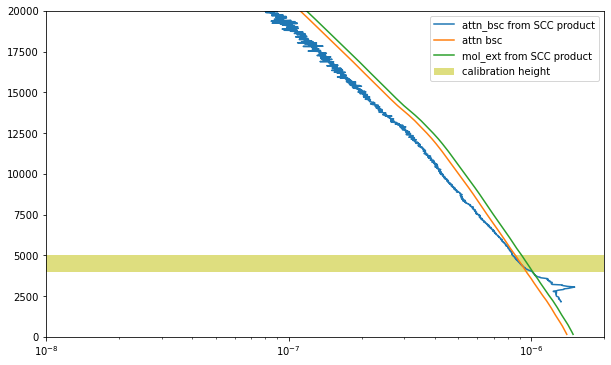

In [93]:
alt = scc_output_data['altitude'][1,:]
fig, ax = plt.subplots(figsize=[10,6])
ax.semilogx(scc_output_data['attenuated_backscatter'][1,1,:] , alt, label='attn_bsc from SCC product')
ax.semilogx(attnbsc_norm, alt, label='attn bsc')
ax.semilogx(scc_output_data['molecular_extinction'][1,1,:]*a, alt, label='mol_ext from SCC product')
ax.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax.legend()
ax.set_ylim(0,20000)
ax.set_xlim(1e-8, 2e-6)

In [120]:
gluing_data = elpp_data['range_corrected_signal'][1,1,:]

In [121]:
pression1pf = elpp_data['pressure'][1,:]#mbar
tempe1pf = elpp_data['temperature'][1,:]#K
Na = 6.0224e23
Ra = 8.31440

In [122]:
molbsc = (Na/Ra)*(pression1pf/tempe1pf)*5.167e-27
molext = molbsc/0.119
tau = np.zeros_like(molext)
for i in range(1, len(molext)):
    tau[i] = molext[0] + molext[i]*(alt[i]-alt[0])
    
tau[0] = scc_molext1pf[0]
attnbsc = molbsc * np.exp(-2*tau)

In [123]:
C = (gluing_data[idx]/attnbsc[idx]).mean(('level'))
print(C)

<xarray.DataArray ()>
array(1.91275614e+42)
Coordinates:
    time     datetime64[ns] 2020-07-08T18:21:23


(0.0, 20000.0)

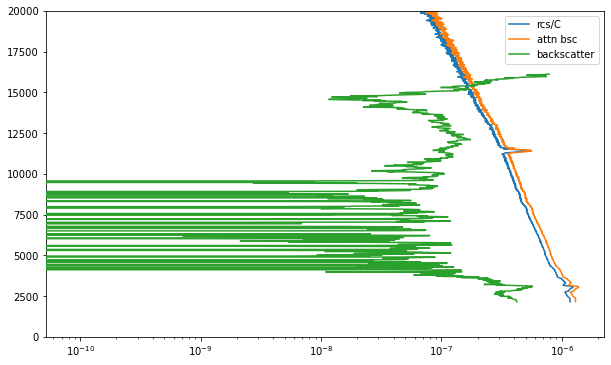

In [147]:
fig, ax = plt.subplots(figsize=[10,6])
ax.semilogx(elpp_data['range_corrected_signal'][1,0,:]/elic_data['attenuated_backscatter_calibration'][1,1], alt, label='rcs/C')
ax.semilogx(elic_data['attenuated_backscatter'][1,0,:], alt, label='attn bsc')
ax.semilogx(elda_data['backscatter'][0,0,:].values, elda_data['altitude'].values, label='backscatter', zorder=10)
ax.legend()
ax.set_ylim(0, 20000)

In [141]:
elda_data['backscatter']

<xarray.DataArray 'backscatter' (wavelength: 1, time: 1, altitude: 932)>
array([[[4.231205e-07, 4.223780e-07, ..., 7.392846e-07, 7.833383e-07]]])
Coordinates:
  * altitude    (altitude) float64 2.158e+03 2.174e+03 ... 1.611e+04 1.612e+04
  * time        (time) datetime64[ns] 2020-07-08T18:00:11.000000256
    latitude    float32 48.71
    longitude   float32 2.208
  * wavelength  (wavelength) float32 532.0
Attributes:
    long_name:            aerosol backscatter coefficient
    units:                1/(m*sr)
    ancillary_variables:  error_backscatter vertical_resolution

In [148]:
elic_data['attenuated_backscatter']


<xarray.DataArray 'attenuated_backscatter' (channel: 2, time: 4, level: 4000)>
array([[[          nan,           nan, ...,  5.544035e-06,  8.196356e-06],
        [          nan,           nan, ...,  1.213475e-06,  2.033786e-06],
        [          nan,           nan, ...,  1.346975e-05,  6.534499e-06],
        [          nan,           nan, ...,  9.651539e-06, -2.020428e-05]],

       [[          nan,           nan, ..., -2.357661e-08, -6.007846e-08],
        [          nan,           nan, ...,  3.454143e-08,  2.329893e-08],
        [          nan,           nan, ..., -2.686771e-08, -6.540148e-08],
        [          nan,           nan, ...,  4.717756e-08,  5.122251e-08]]])
Coordinates:
    altitude  (time, level) float64 ...
  * time      (time) datetime64[ns] 2020-07-08T18:00:11 ... 2020-07-08T18:56:44
Dimensions without coordinates: channel, level
Attributes:
    units:                m-1 sr-1
    long_name:            total attenuated bcakscatter
    ancillary_variables:  attenuated_backscatter_emission_wavelength attenuat...

### APPLIQUER LA METHODE RALEIGH-FIT

In [24]:

def get_altitude_reference(zbottom, ztop, altitude_total):
    '''
    Fonction permet de retrouver la position de l'altitude référence dans le vecteur de l'altitude et la valeur de altitude référence.
    Input:
        zbottom: le borne bas de l'intervale
        ztop: le borne haut de l'intervale
        altitude_total: le vecteur total de l'altitude
    Output:
        la valeur de l'altitude et son indexe dans le vecteur total
    '''
    def arg_median(a):
        '''
        Fonction permet de retrouver la position médiane de la zone de référence de l'altitude
        Input: 
            a = l'intervale de l'altitude où se trouve la zone de référence 
        Ouput:
            Indexe de la position dans cet intervale
        '''
        if len(a) % 2 == 1:
            return np.where(a == np.median(a))[0][0]
        else:
            l,r = len(a) // 2 - 1, len(a) // 2
            left = np.partition(a, l)[l]
            right = np.partition(a, r)[r]
            return np.where(a == left)[0][0]

    interval_ref = altitude_total[(altitude_total >= zbottom) & (altitude_total <= ztop)] 
    idxref = arg_median(interval_ref)
    zref = interval_ref[idxref]
    idxref_in_total = np.where(altitude_total == zref)[0][0]
    return zref, idxref_in_total

zbottom = 2500
ztop = 4500
Zref, idx_ref = get_altitude_reference(zbottom, ztop, ipralrange)

In [25]:
idx_ref

232

In [52]:
    
### Fonction de simulation
def get_attenuation(p, T, idxref, altitude_total, w):
    '''
    Fonction permet de retrouver l'atténuation du coef en fonction de l'altitude, centré autour de l'altitude de référence
    Méthode est de séparer numériquement la série de l'altitude par rapport à celle de référence (inférieur et supérieur) 
    Input:
        idxref: Indexe de la position de l'altitude référence
        alphamol: vecteur de coef. d'extinction moléculaire
        betamol: vecteur de coef. de backscatter moléculaire
    Output: 
        attnC:  vecteur de backscatter moléculaire atténué
    '''
    def get_backscatter_mol(p, T, w):
        '''
        Fonction permet de calculer le coef. de backscatter moléculaire 
        '''
        k = 1.38e-23
        betamol = (p*1e-2)/(k*T) * 5.45e-32 * (w/0.55)**(-4.09)
        alphamol = betamol/0.119
        return alphamol, betamol
    
    alphamol, betamol = get_backscatter_mol(p, T)
    print(type(alphamol), type(betamol))
    
    # z de 0 à zref : index = [0, idxref]
    C = [0]*len(altitude_total)
    C[idxref] = 0
    for i in range(idxref-1, 0, -1):
    #     C[i] = C[i-1] - alphamol[i-1]*(opalt[i]-opalt[i-1])
        C[i] = alphamol[i]*(altitude_total[i+1]-altitude_total[idxref]) +C[i+1]

    # z de zref à fin de l'altitude: index = [idxref,len(alt)]
    for i in range(idxref+1, len(altitude_total)):
        C[i] = alphamol[i]*(altitude_total[i-1]-altitude_total[idxref]) +C[i-1] 
    
#     for i in range(idxref-1, 0, -1):
#         C[i] = alphamol[i]*(altitude_total[i+1] - altitude_total[idxref])
        
#     for i in range(idxref+1, len(altitude_total)):
#         C[i] = alphamol[i]*(altitude_total[i-1] - altitude_total[idxref])
        
    C = np.array(C)
    attnC = betamol*np.exp(-2*C)
    return attnC, C


### Normaliser le signal avec le backscatter moléculaire atténué
def normalisation(min_bounds, max_bounds, altitude_total, rcs, attn_mol_bsc):
    '''
    Calculer le constant de calibration en préciser la zone de référence 
    Normaliser le signal par rapport à au constant de calibration
    '''
    idx = (altitude_total >= min_bounds) & (altitude_total <= max_bounds)
    alt_ref = altitude_total[idx]
    rcs_ref = np.mean(rcs[idx])
    attn_mol_bsc_ref = np.mean(attn_mol_bsc[idx])
    Const = attn_mol_bsc_ref/rcs_ref
    print(Const)
    rcs_norm = rcs*Const
    return rcs_norm



In [27]:
### Lire les temperatures et les pressions
ipralera5 = pd.read_pickle(sorted(Path('/homedata/nmpnguyen/IPRAL/1a/').glob('ipral_1a_Lz1R15mF30sPbck_v01_202002*.pkl'))[0])
taera5 = ipralera5['ta'].unstack(level=1)#.iloc[0,:]
pressionera5 = ipralera5['pression'].unstack(level=1)

### Lire le rcs 532nm et son background 
signal = ipralraw['rcs_17']
bckgrd = ipralraw['bckgrd_rcs_17']
ipralrange = ipralraw['range'].values
rcs = (signal/(ipralrange**2) - bckgrd)*(ipralrange**2)

In [41]:
zbottom = 2500
ztop = 4500
Zref, idx_ref = get_altitude_reference(zbottom, ztop, ipralrange)
print(len(ipralrange))

4000


In [53]:
### 1 profil 
t=30
d = rcs.isel(time = t)
pres = pressionera5.iloc[t,:].values
temp = taera5.iloc[t,:].values
attn_bscmol, opt_depth = get_attenuation(pres, temp, idx_ref, ipralrange, 0.532)
print(attn_bscmol)
d_norm = normalisation(zbottom, ztop, ipralrange, d, attn_bscmol)
sr = d_norm/attn_bscmol

TypeError: get_backscatter_mol() missing 1 required positional argument: 'w'

-------OUTPUT PLOT-------


Text(0.5, 0.98, 'IPRAL')

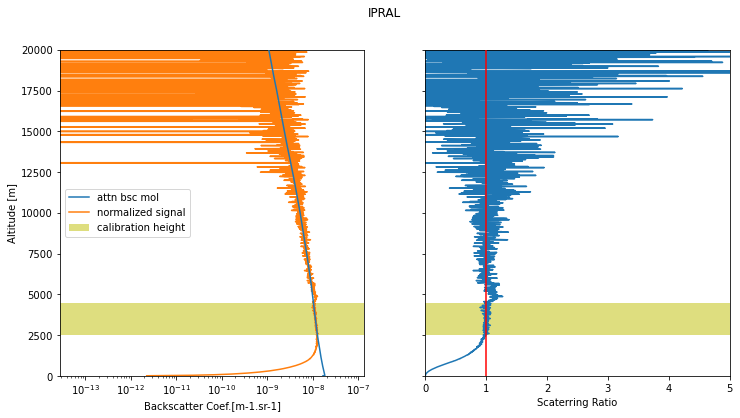

In [49]:
print('-------OUTPUT PLOT-------')
fig, (ax,ax2) = plt.subplots(nrows=1, ncols=2, figsize=[12,6], sharey=True)
ax.semilogx(attn_bscmol, ipralrange, label='attn bsc mol', zorder=10)
ax.semilogx(d_norm, ipralrange, label='normalized signal')
ax.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax.set(xlabel='Backscatter Coef.[m-1.sr-1]', ylabel='Altitude [m]')
ax.legend()
ax.set_ylim(0, 20000)
ax2.plot(sr, ipralrange) 
ax2.set_ylim(0, 20000)
ax2.vlines(1, ymin=ipralrange.min(), ymax=ipralrange.max(), color='r', zorder = 10)
ax2.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax2.set(xlabel='Scaterring Ratio')
ax2.set_xlim(0, 5)
plt.suptitle('IPRAL')

In [50]:
### VERTICAL AVERAGE

d = rcs.isel(time = t)
n = 10; s = 4000
d30 = np.mean(d[:s].values.reshape(-1, n), axis=1)
z30 = np.mean(ipralrange[:s].reshape(-1, n), axis=1)
pres30 = np.mean(pres[:s].reshape(-1, n), axis=1)
temp30 = np.mean(temp[:s].reshape(-1, n), axis=1)#ta.iloc[t,:].values
attn_bscmol30 = np.mean(attn_bscmol[:s].reshape(-1, n), axis=1)
d30_norm = normalisation(zbottom, ztop, z30, d30, attn_bscmol30)
sr30 = d30_norm/attn_bscmol30

7.983979003444059e-17


-------OUTPUT PLOT-------


Text(0.5, 0.98, 'IPRAL')

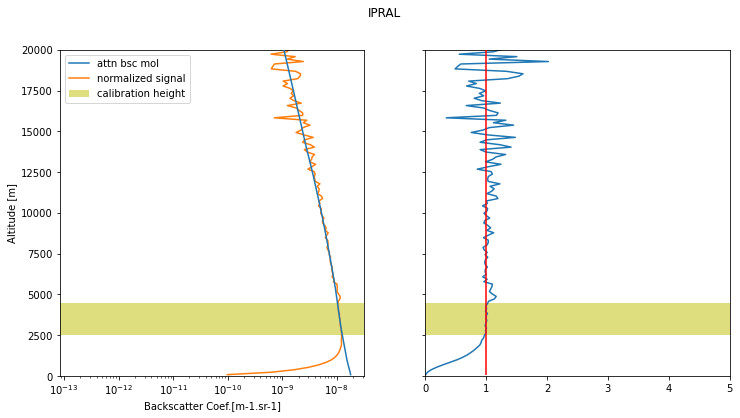

In [51]:
print('-------OUTPUT PLOT-------')
fig, (ax,ax2) = plt.subplots(nrows=1, ncols=2, figsize=[12,6], sharey=True)
ax.semilogx(attn_bscmol30, z30, label='attn bsc mol', zorder=10)
ax.semilogx(d30_norm, z30, label='normalized signal')
ax.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax.set(xlabel='Backscatter Coef.[m-1.sr-1]', ylabel='Altitude [m]')
ax.legend()
ax.set_ylim(0, 20000)
# ax.set_xlim(1e-9, 1e-7)
ax2.plot(sr30, z30) 
ax2.set_ylim(0, 20000)
ax2.vlines(1, ymin=z30.min(), ymax=z30.max(), color='r', zorder = 10)
ax2.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax2.set_xlim(0,5)
plt.suptitle('IPRAL')

In [54]:
pressionera5

range,15.0,30.0,45.0,60.0,75.0,90.0,105.0,120.0,135.0,150.0,...,59865.0,59880.0,59895.0,59910.0,59925.0,59940.0,59955.0,59970.0,59985.0,60000.0
time,,,,,,,,,,,,,,,,,,,,,
2020-02-06 09:51:37.000000000,101071.511526,100898.763564,100726.015603,100553.267641,100380.519679,100207.771718,100035.023756,99862.275795,99689.527833,99516.779871,...,-525.592343,-526.631665,-527.670986,-528.710308,-529.749629,-530.788951,-531.828272,-532.867594,-533.906915,-534.946237
2020-02-06 09:52:08.000000000,101071.511526,100898.763564,100726.015603,100553.267641,100380.519679,100207.771718,100035.023756,99862.275795,99689.527833,99516.779871,...,-525.592343,-526.631665,-527.670986,-528.710308,-529.749629,-530.788951,-531.828272,-532.867594,-533.906915,-534.946237
2020-02-06 09:52:38.000000000,101071.511526,100898.763564,100726.015603,100553.267641,100380.519679,100207.771718,100035.023756,99862.275795,99689.527833,99516.779871,...,-525.592343,-526.631665,-527.670986,-528.710308,-529.749629,-530.788951,-531.828272,-532.867594,-533.906915,-534.946237
2020-02-06 09:53:08.000000000,101071.511526,100898.763564,100726.015603,100553.267641,100380.519679,100207.771718,100035.023756,99862.275795,99689.527833,99516.779871,...,-525.592343,-526.631665,-527.670986,-528.710308,-529.749629,-530.788951,-531.828272,-532.867594,-533.906915,-534.946237
2020-02-06 09:53:38.000000000,101071.511526,100898.763564,100726.015603,100553.267641,100380.519679,100207.771718,100035.023756,99862.275795,99689.527833,99516.779871,...,-525.592343,-526.631665,-527.670986,-528.710308,-529.749629,-530.788951,-531.828272,-532.867594,-533.906915,-534.946237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-06 23:57:04.000000000,101088.400897,100914.873579,100741.346261,100567.818943,100394.291625,100220.764307,100047.236989,99873.709671,99700.182353,99526.655035,...,-505.854453,-506.876032,-507.897610,-508.919189,-509.940767,-510.962346,-511.983924,-513.005503,-514.027081,-515.048660
2020-02-06 23:57:34.000000256,101088.400897,100914.873579,100741.346261,100567.818943,100394.291625,100220.764307,100047.236989,99873.709671,99700.182353,99526.655035,...,-505.854453,-506.876032,-507.897610,-508.919189,-509.940767,-510.962346,-511.983924,-513.005503,-514.027081,-515.048660
2020-02-06 23:58:04.000000000,101088.400897,100914.873579,100741.346261,100567.818943,100394.291625,100220.764307,100047.236989,99873.709671,99700.182353,99526.655035,...,-505.854453,-506.876032,-507.897610,-508.919189,-509.940767,-510.962346,-511.983924,-513.005503,-514.027081,-515.048660


### Without / With ipral_chm15k_cloud_filter.py

In [158]:
# load data------------------
date = pd.to_datetime("2021-01-25")
IPRAL_PATH = Path("/bdd/SIRTA/pub/basesirta/1a/ipral/")
IPRAL_DIR = IPRAL_PATH / f"{date:%Y}" / f"{date:%m}" / f"{date:%d}"
IPRAL_MASK = "ipral_1a_Lz1R15mF30sPbck_v01_*_000000_1440.nc"
file_ipral=sorted(IPRAL_PATH.glob('**/**/ipral_1a_Lz1R15mF30sPbck_v01_*_000000_1440.nc'))[0]

In [98]:
file_ipral= Path('/bdd/SIRTA/pub/basesirta/1a/ipral/2020/01/16/ipral_1a_Lz1R15mF30sPbck_v01_20200116_000000_1440.nc')
data = xr.open_dataset(file_ipral)
data

<xarray.Dataset>
Dimensions:                (n_chan: 18, nv: 2, range: 4000, time: 639)
Coordinates:
  * time                   (time) datetime64[ns] 2020-01-16T10:03:49.99999974...
  * range                  (range) float32 15.0 30.0 45.0 ... 5.998e+04 6e+04
Dimensions without coordinates: n_chan, nv
Data variables: (12/73)
    time_bnds              (time, nv) datetime64[ns] ...
    lat                    float32 ...
    lon                    float32 ...
    altitude               float32 ...
    wavelength             (n_chan) float32 ...
    telescope              (n_chan) int32 ...
    ...                     ...
    bckgrd_rcs_16          (time) float64 ...
    rcs_17                 (time, range) float64 ...
    bckgrd_rcs_17          (time) float64 ...
    time_resol             (time) float32 ...
    range_resol            float32 ...
    tilt_angle             float32 ...
Attributes: (12/73)
    system:                          CNRS/IPSL IPRAL RAMAN multiwavelength Lidar
    manufacturers:                   Gordien Strato, Raymetrics, Spectra physics
    overlap_is_corrected:            false
    overlap_function:                false
    site_location:                   Palaiseau, France
    instrument_id:                   IPRAL
    ...                              ...
    telescope0_type:                 Enhanced Cassegrain+Nasmith
    telescope0_manufacturer:         Gordien Strato
    telescope0_model:                special
    telescope1_type:                 Newton
    telescope1_manufacturer:         Gordien Strato
    telescope1_model:                special

/mnt/homedafs-2.5/lov/homedata/nmpnguyen/python_envs/ipral_tools/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


[Text(0.5, 1.0, 'SIRTA IPRAL: 355NR Photocounting')]

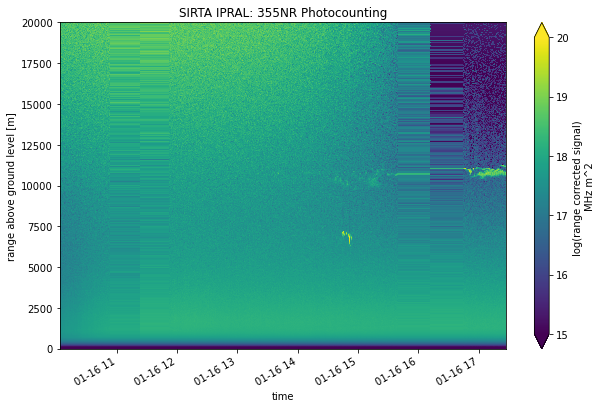

In [99]:
# plot rcs_13----------------
fig, ax = plt.subplots(figsize=[10, 6])
np.log(data.rcs_13).plot(ax=ax, x='time', vmin=15, vmax=20, 
                         cbar_kwargs = dict(label='log(range corrected signal) \nMHz m^2'))
ax.set_ylim(0, 20000)
ax.set(title='SIRTA IPRAL: 355NR Photocounting')

In [100]:
time = data.time.values
channel = 13
r = data.range.values
r_square = np.square(r)
channel_rcs = 'rcs_'+str(channel)
channel_bckgrd = 'bckgrd_rcs_'+str(channel)
ipr = data[channel_rcs].values
bck = data[channel_bckgrd].values
tmp = ipr/r_square.reshape((1, r_square.size)) - bck.reshape((bck.size, 1))
rcs = tmp*r_square.reshape((1, r_square.size))
# rcs = pd.DataFrame(data=rcs, index=time, columns=np.float64(r))
print(time)

['2020-01-16T10:03:49.999999744' '2020-01-16T10:04:20.000000000'
 '2020-01-16T10:04:50.000000000' '2020-01-16T10:05:20.000000000'
 '2020-01-16T10:05:50.999999744' '2020-01-16T10:06:21.000000000'
 '2020-01-16T10:06:51.000000000' '2020-01-16T10:07:22.000000000'
 '2020-01-16T10:07:51.999999744' '2020-01-16T10:08:22.000000000'
 '2020-01-16T10:08:52.000000000' '2020-01-16T10:09:23.000000000'
 '2020-01-16T10:09:52.999999744' '2020-01-16T10:10:23.000000000'
 '2020-01-16T10:10:54.000000000' '2020-01-16T10:11:24.000000000'
 '2020-01-16T10:11:53.999999744' '2020-01-16T10:12:24.000000000'
 '2020-01-16T10:12:55.000000000' '2020-01-16T10:13:25.000000000'
 '2020-01-16T10:13:55.000000000' '2020-01-16T10:14:26.000000000'
 '2020-01-16T10:14:56.000000000' '2020-01-16T10:15:26.000000000'
 '2020-01-16T10:15:57.000000000' '2020-01-16T10:16:27.000000000'
 '2020-01-16T10:16:57.000000000' '2020-01-16T10:17:27.000000000'
 '2020-01-16T10:17:58.000000000' '2020-01-16T10:18:28.000000000'
 '2020-01-16T10:18:58.000

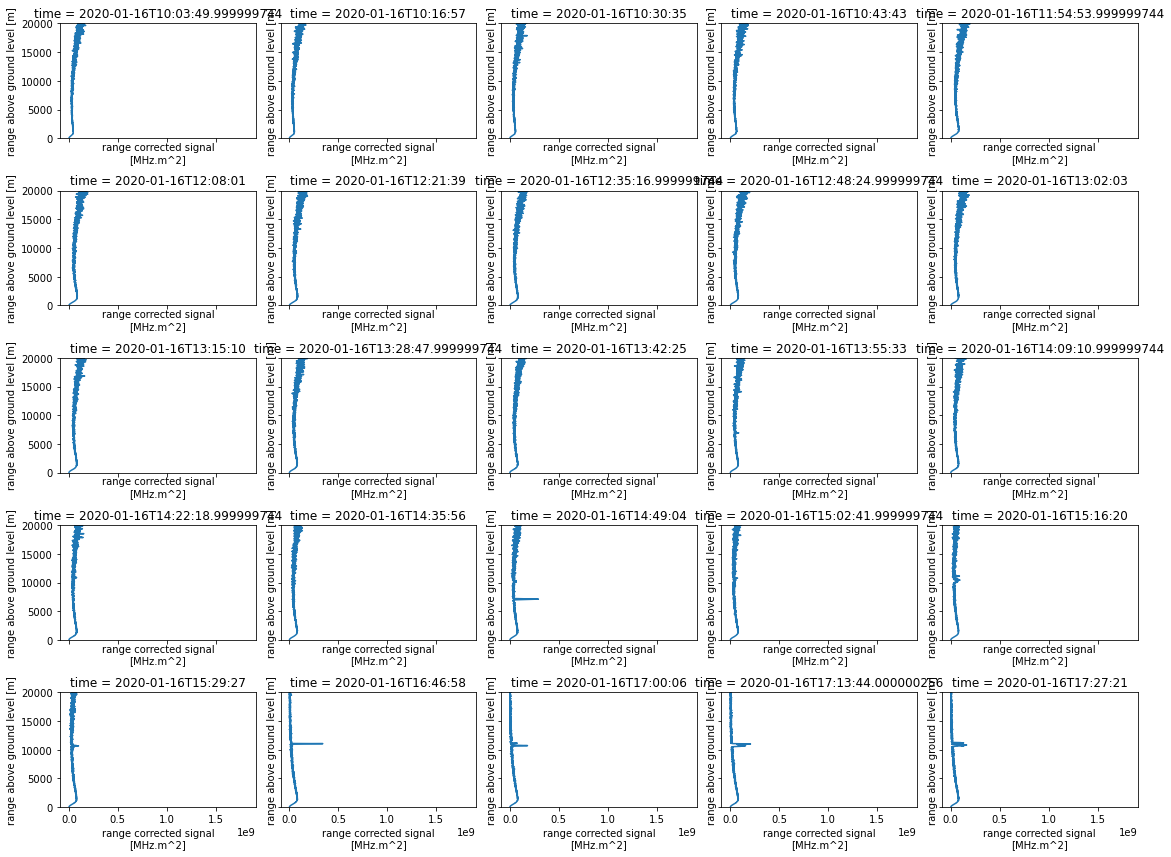

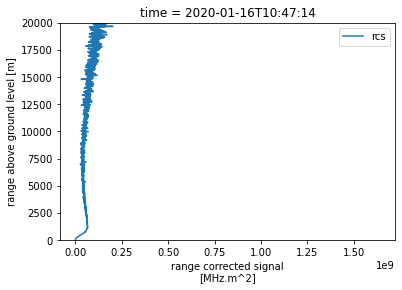

In [102]:
fig, axs = plt.subplots(figsize=(16,12), ncols=5, nrows=5, sharey=True, sharex=True)
N = np.int_(np.linspace(0, len(time)-1, 25))
for n, ax in enumerate(axs.flatten()):
    data.isel(time=N[n])['rcs_13'].plot(y='range', ax=ax)
#     ax.plot(rcs[N[n],:], r, label=channel_rcs)
    ax.set_ylim(0, 20000)

# plt.suptitle(str(ipral_file.name) + "\n Range background correction")
plt.tight_layout()

f, ax = plt.subplots()
data.sel(time='2020-01-16T10:47:14.000000000')['rcs_13'].plot(y='range', ax=ax, label='rcs')
# ax.plot(rcs[10,:], data['range'].values, label='rcs-bck')
ax.set_ylim(0, 20000)
ax.legend()

In [69]:
import sys
sys.path.append('/homedata/nmpnguyen/ipral-tools/')
from imp import reload as rl
# rl(ipral_chm15k_cloud_filter)
from ipral_chm15k_cloud_filter import ipral_remove_cloud_profiles as cloud_filter
# rl(ipral_variables_simulation)
# from ipral_variables_simulation import simulate 

In [103]:
data_after = cloud_filter(date=pd.to_datetime(file_ipral.name.split('_')[4]), alt_max=4000, ipral_file=file_ipral, output=Path('/home/nmpnguyen/', file_ipral.name))
# print(data_after)

Processing 2020-01-16
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2020/01/16/chm15k_1a_z1Ppr2R15mF15s_v01_20200116_000000_1440.nc
639 in IPRAL data
0 profiles will be remove
saving in /home/nmpnguyen/ipral_1a_Lz1R15mF30sPbck_v01_20200116_000000_1440.nc


In [104]:
time_after = data_after.time.values
channel = 13
r_after = data_after.range.values
r_square_after = np.square(r_after)
channel_rcs = 'rcs_'+str(channel)
channel_bckgrd = 'bckgrd_rcs_'+str(channel)
ipr_after = data_after[channel_rcs].values
bck_after = data_after[channel_bckgrd].values
tmp_after = ipr_after/r_square_after.reshape((1, r_square_after.size)) - bck_after.reshape((bck_after.size, 1))
rcs_after = tmp_after*r_square_after.reshape((1, r_square_after.size))
# rcs = pd.DataFrame(data=rcs, index=time, columns=np.float64(r))
print(time_after)

['2020-01-16T10:03:49.999999744' '2020-01-16T10:04:20.000000000'
 '2020-01-16T10:04:50.000000000' '2020-01-16T10:05:20.000000000'
 '2020-01-16T10:05:50.999999744' '2020-01-16T10:06:21.000000000'
 '2020-01-16T10:06:51.000000000' '2020-01-16T10:07:22.000000000'
 '2020-01-16T10:07:51.999999744' '2020-01-16T10:08:22.000000000'
 '2020-01-16T10:08:52.000000000' '2020-01-16T10:09:23.000000000'
 '2020-01-16T10:09:52.999999744' '2020-01-16T10:10:23.000000000'
 '2020-01-16T10:10:54.000000000' '2020-01-16T10:11:24.000000000'
 '2020-01-16T10:11:53.999999744' '2020-01-16T10:12:24.000000000'
 '2020-01-16T10:12:55.000000000' '2020-01-16T10:13:25.000000000'
 '2020-01-16T10:13:55.000000000' '2020-01-16T10:14:26.000000000'
 '2020-01-16T10:14:56.000000000' '2020-01-16T10:15:26.000000000'
 '2020-01-16T10:15:57.000000000' '2020-01-16T10:16:27.000000000'
 '2020-01-16T10:16:57.000000000' '2020-01-16T10:17:27.000000000'
 '2020-01-16T10:17:58.000000000' '2020-01-16T10:18:28.000000000'
 '2020-01-16T10:18:58.000

/mnt/homedafs-2.5/lov/homedata/nmpnguyen/python_envs/ipral_tools/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


[Text(0.5, 1.0, 'SIRTA IPRAL: 355NR Photocounting \ncloud filter under 4000m')]

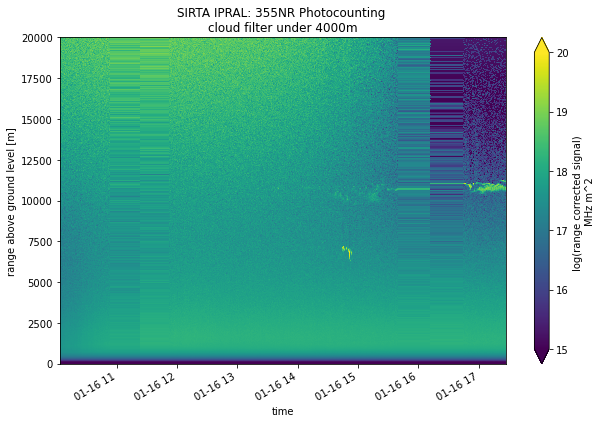

In [105]:
# plot rcs_13----------------
fig, ax = plt.subplots(figsize=[10, 6])
np.log(data_after.rcs_13).plot(ax=ax, x='time', vmin=15, vmax=20, 
                         cbar_kwargs = dict(label='log(range corrected signal) \nMHz m^2'))
ax.set_ylim(0, 20000)
ax.set(title='SIRTA IPRAL: 355NR Photocounting \ncloud filter under 4000m')

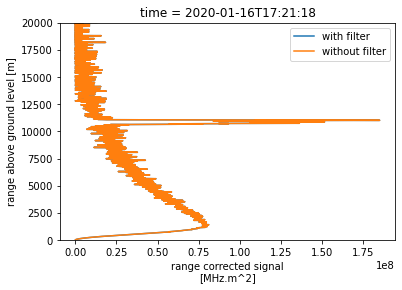

In [108]:
# fig, axs = plt.subplots(figsize=(16,12), ncols=5, nrows=5, sharey=True, sharex=True)
# N = np.int_(np.linspace(0, len(time_after)-1, 25))
# for n, ax in enumerate(axs.flatten()):
#     data_after.isel(time=N[n])['rcs_13'].plot(y='range', ax=ax)
# #     ax.plot(rcs[N[n],:], r, label=channel_rcs)
#     ax.set_ylim(0, 20000)
# # plt.suptitle(str(ipral_file.name) + "\n Range background correction")
# plt.tight_layout()

f, ax = plt.subplots()
data_after.sel(time='2020-01-16T17:21:18.000000000')['rcs_13'].plot(y='range', ax=ax, label='with filter')
data.sel(time='2020-01-16T17:21:18.000000000')['rcs_13'].plot(y='range', ax=ax, label='without filter')
# ax.plot(rcs[10,:], data['range'].values, label='rcs-bck')
ax.set_ylim(0, 20000)
ax.legend()

## Interpreter nouvel résultat

In [41]:
new_path = Path('/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180426_000000_1440.nc')
new = xr.open_dataset(new_path)
new.coords["wavelength"][0]

<xarray.DataArray 'wavelength' ()>
array(355)
Coordinates:
    wavelength  int64 355

/mnt/homedafs-2.5/lov/homedata/nmpnguyen/python_envs/ipral_tools/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


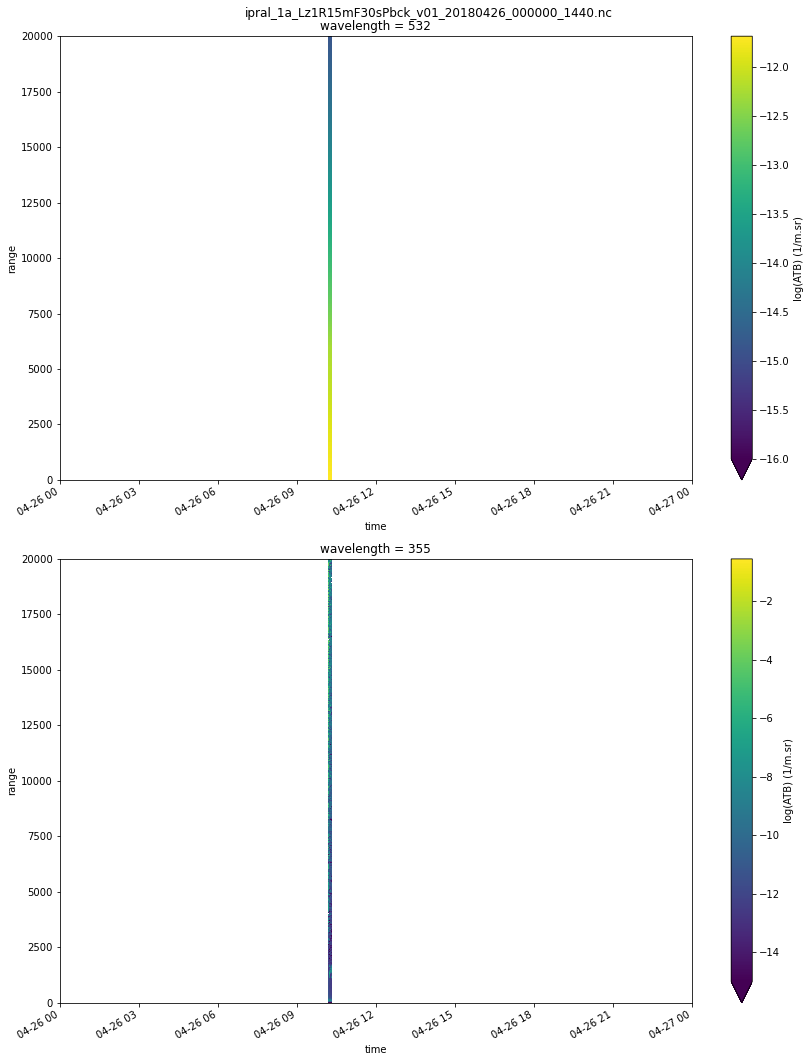

In [42]:
f, ax = plt.subplots(figsize=[12,15], nrows=2, ncols=1)
np.log(new.isel(wavelength = 1)['calibrated']).plot(x='time', y='range', ax=ax[0], vmin=-16, cbar_kwargs={"label": "log(ATB) (1/m.sr)"})
np.log(new.isel(wavelength = 0)['calibrated']).plot(x='time', y='range', ax=ax[1], vmin=-15, cbar_kwargs={"label": "log(ATB) (1/m.sr)"})
ax[0].set_ylim(0,20000)
ax[0].set_xlim(pd.to_datetime(new_path.name.split('_')[4]), pd.to_datetime(new_path.name.split('_')[4])+pd.DateOffset(1))
ax[1].set_ylim(0,20000)
ax[1].set_xlim(pd.to_datetime(new_path.name.split('_')[4]), pd.to_datetime(new_path.name.split('_')[4])+pd.DateOffset(1))
plt.suptitle(f'{new_path.name}')
plt.tight_layout()

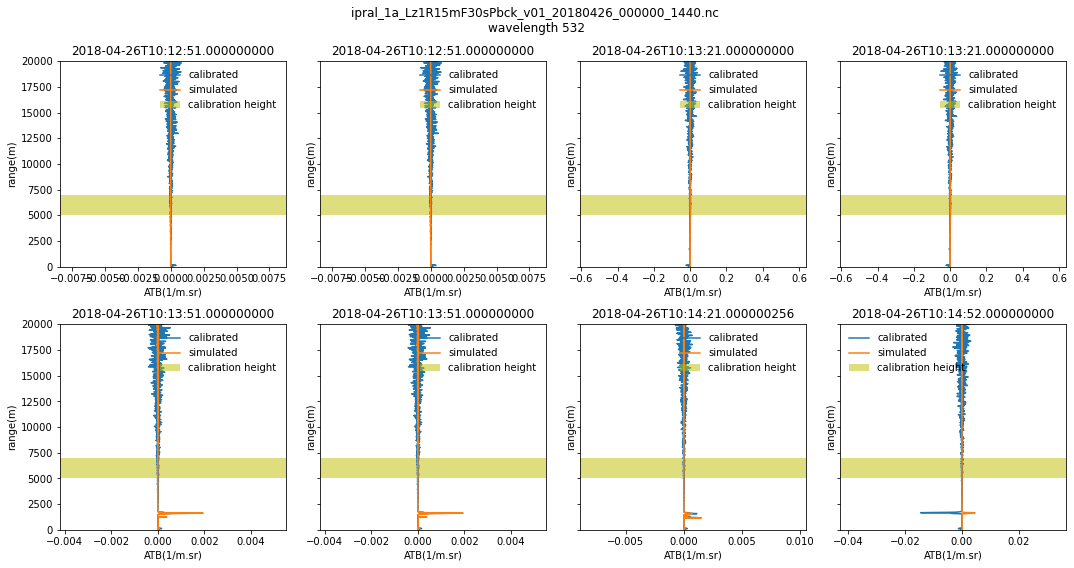

In [43]:
N = np.int_(np.linspace(0, len(new['time'])-1, 20))
f, axs = plt.subplots(figsize=[15,8], nrows=2, ncols=4, sharey=True)
for n, ax in enumerate(axs.flatten()):
    (new.isel(time=N[n], wavelength=0)['calibrated']).plot(y='range', label='calibrated', ax=ax)
    (new.isel(time=N[n], wavelength=0)['simulated']).plot(y='range', label='simulated', ax=ax)
    ax.axhspan(new.attrs['calibration height'][0], new.attrs['calibration height'][1], color='y', alpha=0.5, lw=0, label='calibration height')
    ax.legend(loc='best', frameon=False)
    ax.set_ylim(0,20000)
    ax.set(title = new['time'][N[n]].values, ylabel = 'range(m)', xlabel = 'ATB(1/m.sr)')
    
plt.suptitle(f'{new_path.name} \nwavelength {new["wavelength"][1].values}')
plt.tight_layout()

# fig, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=[12,7], sharey=True)#
# new.isel(wavelength=0).sel(time='2021-01-25T18:15:20.000000000')['calibrated'].plot(y='range', ax=ax3, label='calibrated')
# new.isel(wavelength=0).sel(time='2021-01-25T18:15:20.000000000')['simulated'].plot(y='range', ax=ax3, label='simulated')
# ax3.axhspan(new.attrs['calibration height'][0], new.attrs['calibration height'][1], color='y', alpha=0.5, lw=0, label='calibration height')
# leg3 = ax3.legend(loc='best', frameon=False)
# ax3.set(xlabel='backscatter, 1/m.sr')
# ax3.set_ylim(0,20000)
# ax3.set_xlim(-1e-6, 0.5e-5)
# (new.isel(wavelength=0).sel(time='2021-01-25T18:15:20.000000000')['calibrated']/new.isel(wavelength=0).sel(time='2021-01-25T18:15:20.000000000')['simulated']).plot(y='range', ax=ax4, label='sr')
# ax4.axvline(1, zorder=10, color='r')
# ax4.axhspan(new.attrs['calibration height'][0], new.attrs['calibration height'][1], color='y', alpha=0.5, lw=0, label='calibration height')
# ax4.set(xlabel='Scattering ratio')
# ax4.set_xlim(0, 3.5)
# ax4.set_ylim(0,20000)

<xarray.DataArray ()>
array(0.00013982)
Coordinates:
    time        datetime64[ns] 2019-06-27T00:05:14.000000256
    wavelength  int64 532


(0.0, 20000.0)

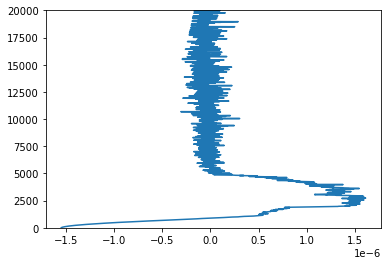

In [80]:
residual = 0
for z in range(len(new['range'])):
    residual = residual + (new['calibrated'][0,10,z] - new['simulated'][0,10,z])

print(residual)
# with open('/home/nmpnguyen/residus_by_profil.txt', 'w') as f:
#     print(residual)
    
# f.close()


fig, ax = plt.subplots()
ax.plot(new['calibrated'][0,10] - new['simulated'][0,10], new['range'].values)
ax.set_ylim(0,20000)

### Distribution des SR

In [3]:
listfiles = sorted(Path('/homedata/nmpnguyen/IPRAL/RF/Calibrated/').glob('*_1440.nc'))
'''
Etape 1: Sélectioner les ATB en 355 et 532 (éviter les NaN, n'accepte que les valeurs 
signicatives intersectées entre des mesures de 2 longeurs d'onde )
'''
atb532 = np.array([], dtype=np.float)
atb355 = np.array([], dtype=np.float)

 
for file in (listfiles):
    print(file)
    loaded = xr.open_dataset(file)
    limite = np.where((loaded['range']>5000)&(loaded['range']<20000))[0]
    calibrated355 = loaded.isel(wavelength=0, range=limite)['calibrated'].values.flatten()
    calibrated532 = loaded.isel(wavelength=1, range=limite)['calibrated'].values.flatten()
    ids = np.intersect1d(np.where(~np.isnan(calibrated355))[0], np.where(~np.isnan(calibrated532))[0])
    atb532 = np.concatenate((atb532, calibrated532[ids]))
    atb355 = np.concatenate((atb355, calibrated355[ids]))


/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180221_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180222_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180223_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180224_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180225_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20190215_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20190218_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20190219_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20190220_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20190221_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_2

In [151]:
atb532.shape, atb355.shape

((63386000,), (63386000,))

(0.0, 1e-05)

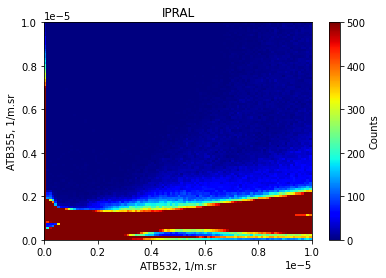

In [149]:
'''
Etape 2: Tracer la distribuion des ATB 355 en fonction de ATB 532, 
en couleur linéaire
'''
f, ax = plt.subplots()
h = ax.hist2d(atb532, atb355, bins=100, cmap='jet', range = [[0, 1e-5], [0, 1e-5]])
c = plt.colorbar(h[3], ax=ax, label='Counts')
# h[3].set_clim(0, 500)
ax.set(xlabel='ATB532, 1/m.sr', ylabel='ATB355, 1/m.sr', title='IPRAL')
ax.set_xlim(0, 1e-5)
ax.set_ylim(0, 1e-5)

(0.0, 1e-05)

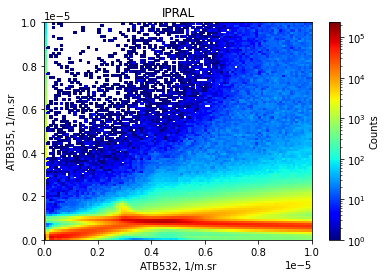

In [153]:
'''
Etape 2+: La distribution en Log
'''
from matplotlib.colors import LogNorm

f, ax = plt.subplots()
h = ax.hist2d(atb532, atb355, bins=100, cmap='jet', range = [[0, 1e-5], [0, 1e-5]], norm=LogNorm())
c = plt.colorbar(h[3], ax=ax, label='Counts')
# h[3].set_clim(0, 500)
ax.set(xlabel='ATB532, 1/m.sr', ylabel='ATB355, 1/m.sr', title='IPRAL')
ax.set_xlim(0, 1e-5)
ax.set_ylim(0, 1e-5)

In [16]:
'''
Etape 3: En déduire la distribution des SR
'''
# listfiles = sorted(Path('/homedata/nmpnguyen/IPRAL/RF/Calibrated/').glob('*_1440.nc'))
# sr532H = np.array([], dtype=np.float)
# sr355H = np.array([], dtype=np.float)

# for file in listfiles[:3]:
#     print(file)
#     loaded = xr.open_dataset(file)
#     limite = np.where((loaded['range']>5000)&(loaded['range']<20000))[0]
#     sr532 = (loaded.isel(wavelength=1, range=limite)['calibrated']/loaded.isel(wavelength=1, range=limite)['simulated']).values.flatten()
# #     print(np.argmax(sr532.values, axis=0))
#     sr355 = (loaded.isel(wavelength=0, range=limite)['calibrated']/loaded.isel(wavelength=0, range=limite)['simulated']).values.flatten()
# #     print(len(loaded['time'].values),len(np.argmax(sr355.values, axis=1)),np.argmax(sr355.values, axis=1))
#     ids = ~np.isinf(sr355) & ~np.isinf(sr532)
#     sr532H = np.concatenate((sr532H, sr532[ids]))
#     sr355H = np.concatenate((sr355H, sr355[ids]))

/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180221_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180222_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180223_000000_1440.nc


In [93]:
'''
Etape 3+: En déduire la distribution des SR
'''
listfiles = sorted(Path('/homedata/nmpnguyen/IPRAL/RF/Calibrated/clouds/').glob('*_1440.nc'))

loaded = xr.open_dataset(listfiles[0])
limite = np.where((loaded['range']>5000)&
                  (loaded['range']<20000))[0]
atb355 = xr.open_dataset(listfiles[0]).isel(wavelength=0, range=limite)['calibrated']
si355 = xr.open_dataset(listfiles[0]).isel(wavelength=0, range=limite)['simulated']
sr355 = loaded.isel(wavelength=0, range=limite)['calibrated']/loaded.isel(wavelength=0, range=limite)['simulated']
atb532 = xr.open_dataset(listfiles[0]).isel(wavelength=1, range=limite)['calibrated']
si532 = xr.open_dataset(listfiles[0]).isel(wavelength=1, range=limite)['simulated']
sr532 = loaded.isel(wavelength=1, range=limite)['calibrated']/loaded.isel(wavelength=1, range=limite)['simulated']

ids = np.intersect1d(np.where(~np.isinf(sr355.values.flatten()))[0], np.where(~np.isinf(sr532.values.flatten()))[0])

for file in listfiles[:38]:
    loaded = xr.open_dataset(file)
    print(file)
#     atb532 = xr.concat([atb532, loaded.isel(wavelength=0, range=limite)['calibrated']], dim='time')
#     atb355 = xr.concat([atb355, loaded.isel(wavelength=1, range=limite)['calibrated']], dim='time')
#     si532 = xr.concat([si532, loaded.isel(wavelength=0, range=limite)['simulated']], dim='time')
#     si355 = xr.concat([si355, loaded.isel(wavelength=1, range=limite)['simulated']], dim='time')
    sr355 = xr.concat([sr355, loaded.isel(wavelength=0, range=limite)['calibrated']/loaded.isel(wavelength=0, range=limite)['simulated']], dim='time')
    sr532 = xr.concat([sr532, loaded.isel(wavelength=1, range=limite)['calibrated']/loaded.isel(wavelength=1, range=limite)['simulated']], dim='time')

/homedata/nmpnguyen/IPRAL/RF/Calibrated/clouds/ipral_1a_Lz1R15mF30sPbck_v01_20180228_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/clouds/ipral_1a_Lz1R15mF30sPbck_v01_20180314_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/clouds/ipral_1a_Lz1R15mF30sPbck_v01_20180411_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/clouds/ipral_1a_Lz1R15mF30sPbck_v01_20180418_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/clouds/ipral_1a_Lz1R15mF30sPbck_v01_20180421_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/clouds/ipral_1a_Lz1R15mF30sPbck_v01_20180422_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/clouds/ipral_1a_Lz1R15mF30sPbck_v01_20180424_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/clouds/ipral_1a_Lz1R15mF30sPbck_v01_20180509_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/clouds/ipral_1a_Lz1R15mF30sPbck_v01_20180518_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/clouds/ipral_1a_Lz1R15mF30sPbck_v01_20180522_000000_1440.nc


In [94]:
sr532mean = sr532#.resample(time='5min').mean()
sr355mean = sr355#.resample(time='5min').mean()
sr355H = sr355mean.values.flatten()
sr532H = sr532mean.values.flatten()

In [95]:
from scipy import stats
mask = ~np.isnan(sr532H) & ~np.isnan(sr355H)
with np.errstate(invalid='ignore'):
    slope, intercept, r_value, p_value, std_err = stats.linregress(sr532H[mask], sr355H[mask])
    
fitLine = slope * sr532H + intercept
slope, intercept

H = np.histogram2d(sr532H[mask], sr355H[mask], bins=100, range = [[0, 100], [0, 100]]) #
Hprobas = H[0]/len(sr355H)*100
Xxedges, Yyedges = np.meshgrid(H[1], H[2])

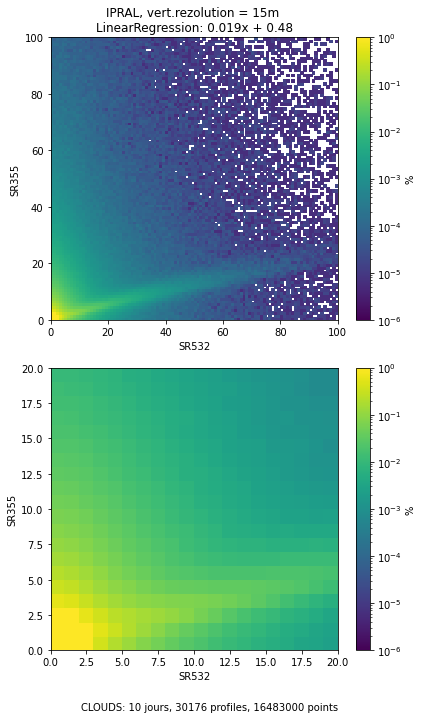

In [96]:
plt.rcParams['agg.path.chunksize'] = 10000

ff, (ax, axins) = plt.subplots(figsize=[6,10], nrows=2)

p = ax.pcolormesh(Xxedges, Yyedges, Hprobas.T, norm = LogNorm(vmax=1e0, vmin=1e-6))
# ax.plot(sr532H, fitLine, '--', c='r')
c = plt.colorbar(p, ax=ax, label='%')
ax.set(xlabel='SR532', ylabel='SR355', 
       title= f'IPRAL, vert.rezolution = 15m \nLinearRegression: {round(slope,3)}x + {round(intercept,3)}')
ax.set(xlim=(0,100), ylim=(0,100))

pins = axins.pcolormesh(Xxedges, Yyedges, Hprobas.T, norm = LogNorm(vmax=1e0, vmin=1e-6))
cins = plt.colorbar(pins, ax=axins, label='%')
# axins.plot(sr532H, fitLine, c='r') # regression fit line 
axins.set_ylim(0, 20)
axins.set_xlim(0, 20)
axins.set(xlabel='SR532', ylabel='SR355')
# Add a footnote below and to the right side of the chart
footnote = f'CLOUDS: {len(listfiles)} jours, {nb_profils} profiles, {len(sr355H)} points'
axins.annotate(footnote,
            xy = (1.0, -0.2),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)
ff.tight_layout()
# axins = inset_axes(ax, width="50%", height="50%")
# pins = axins.pcolormesh(Xxedges, Yyedges, Hprobas.T, norm = LogNorm(vmax=1e-02, vmin=1e-4))
# plt.setp(axins.get_xticklabels(), rotation=45)
# # 
# axins.set_ylim(0, 20)
# axins.set_xlim(0, 20)
# # cins = plt.colorbar(pins, ax=axins, label='%')
# # colorbar
# cax = inset_axes(axins,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="100%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(1.05, 0., 1, 1),
#                  bbox_transform=axins.transAxes,
#                  borderpad=0,
#                  )
# ff.colorbar(pins, cax=cax)
# pp, p1, p2 = mark_inset(ax, axins, loc1=3, loc2=4, fill=False, 
#                         edgecolor="k", linestyle="--", zorder=0, linewidth=0.75)

In [89]:
nb_profils = 0
for file in listfiles:
    loaded = xr.open_dataset(file)
    nb_profils = nb_profils + len(loaded['time'])

In [90]:
len(listfiles), nb_profils, len(sr532H)

(17, 30176, 33021000)

#### Vérifier les profils dont SR532 = 60 et SR355 = 20

In [234]:
listfiles = sorted(Path('/homedata/nmpnguyen/IPRAL/RF/Calibrated/').glob('*2018*_1440.nc'))
sr_limite = [60,20] #SR532~60 et SR355~20
sr532H = np.array([[],[]], dtype=np.float)
sr355H = np.array([[],[]], dtype=np.float)
alltimes = np.array([], dtype='datetime64[ns]')

for file in listfiles:
    print(file)
    loaded = xr.open_dataset(file)
    limite = np.where((loaded['range']>5000)&(loaded['range']<14000))[0]
    sr532 = (loaded.isel(wavelength=1, range=limite)['calibrated']/loaded.isel(wavelength=1, range=limite)['simulated']).values#.flatten()
#     print(np.argmax(sr532.values, axis=0))
    sr355 = (loaded.isel(wavelength=0, range=limite)['calibrated']/loaded.isel(wavelength=0, range=limite)['simulated']).values#.flatten()
    ids = np.where((sr355>=20)&(sr532>=60))[0] #
#     print(ids)
#     sr355H = np.concatenate((sr355H, sr355), axis=0)
#     sr532H = np.concatenate((sr532H, sr532), axis=0)    
    alltimes = np.concatenate((alltimes, loaded['time'][ids].values))

/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180221_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180222_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180223_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180224_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180225_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180226_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180227_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180228_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180314_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180320_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_2

/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180926_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180927_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180928_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180929_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180930_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20181001_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20181003_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20181004_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20181005_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20181008_000000_1440.nc
/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_2

In [236]:
np.unique(alltimes)

with open('timeofproblems.npy', 'wb') as f:
    np.save(f, np.unique(alltimes))

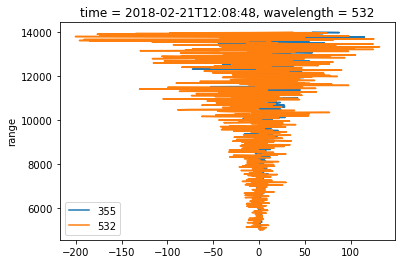

In [60]:
f=xr.open_dataset('/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180221_000000_1440.nc')
fig, ax = plt.subplots()
(f['calibrated']/f['simulated']).isel(wavelength=0, range=limite).sel(time='2018-02-21T12:08:48.000000000').plot(y='range', label='355', ax=ax)
(f['calibrated']/f['simulated']).isel(wavelength=1, range=limite).sel(time='2018-02-21T12:08:48.000000000').plot(y='range', label='532', ax=ax)
ax.legend()

In [259]:
f=xr.open_dataset(sorted(Path("/bdd/SIRTA/pub/basesirta/1a/ipral/2018/").glob('**/**/ipral_1a_Lz1R15mF30sPbck_v01_20180221_000000_1440.nc'))[0])
filecorrectsignal = (f['rcs_13']/np.square(f['range']) - f['bckgrd_'+'rcs_13'])*np.square(f['range'])
data = filecorrectsignal.isel(range=limiteZ).values
len(data)

817

In [237]:
with open('/home/nmpnguyen/timeofproblems.npy', 'rb') as f:
    alltimes = np.load(f)

In [251]:
from datetime import datetime
datefile = np.unique([datetime.strftime(pd.to_datetime(t), '%Y%m%d') for t in alltimes])

## Calculer des résidus 

In [61]:
def residus_alt(new, channelnb):
    limite = np.where((new['range']>5000)&(new['range']<20000))[0]
    residues = new.isel(wavelength=channelnb)['calibrated']-new.isel(wavelength=channelnb)['simulated']
    residue = np.nansum(residues, axis=1)   
    return residue, residues

residu532 = residus_alt(f, 1)
residu355 = residus_alt(f, 0)
residu532[1]

[Text(0.5, 0, 'SR')]

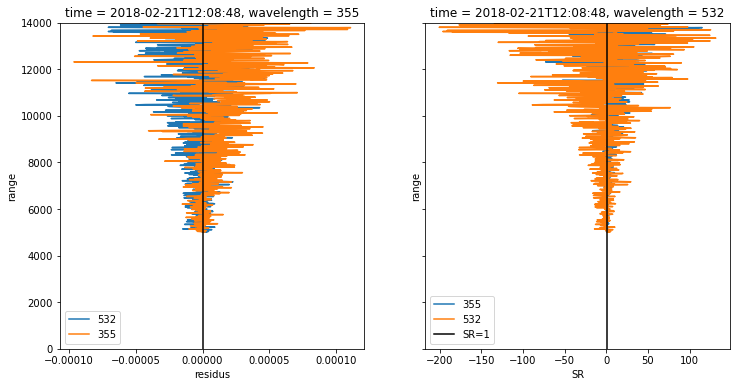

In [106]:
fg, (ax, ax2) = plt.subplots(ncols=2, figsize=[12,6], sharey=True)
residu532[1].sel(time='2018-02-21T12:08:48.000000000').isel(range=limite).plot(y='range', ax=ax, ylim=(0,14000), label='532')
residu355[1].sel(time='2018-02-21T12:08:48.000000000').isel(range=limite).plot(y='range', ax=ax, ylim=(0,14000), label='355')
ax.axvline(0, c='k')
ax.legend()
ax.set(xlabel='residus')
(f['calibrated']/f['simulated']).isel(wavelength=0, range=limite).sel(time='2018-02-21T12:08:48.000000000').plot(y='range', label='355', ax=ax2)
(f['calibrated']/f['simulated']).isel(wavelength=1, range=limite).sel(time='2018-02-21T12:08:48.000000000').plot(y='range', label='532', ax=ax2)
ax2.axvline(1, c='k', label='SR=1')
ax2.legend()
ax2.set(xlabel='SR')

In [151]:
def filter_profile_file(file, channel, limiteTop, limiteBottom):
    filecorrected = (file[channel]/np.square(file['range']) - file['bckgrd_'+channel])*np.square(file['range'])
    limite = (file['range']>limiteTop[0]) & (file['range']<limiteTop[1])
    meanTop = filecorrected.isel(range=limite).mean(dim='range')
    limite = (file['range']>limiteBottom[0]) & (file['range']<limiteBottom[1])
    meanBottom = filecorrected.isel(range=limite).mean(dim='range')
    index_mask = (np.array(meanTop-meanBottom)<0) #selectionner le profil correct
    return index_mask

ipralpath = Path('/bdd/SIRTA/pub/basesirta/1a/ipral/2018/04/06/ipral_1a_Lz1R15mF30sPbck_v01_20180406_000000_1440.nc')
file=xr.open_dataset(ipralpath)
idsmask = filter_profile_file(file, 'rcs_12', [25000,27000], [2000,3000])




In [202]:
# print((file['rcs_12']/np.square(file['range'])).isel(time=0),file['bckgrd_'+'rcs_12'].isel(time=0))
print((file['rcs_12']/np.square(file['range'])).isel(time=0)-file['bckgrd_'+'rcs_12'].isel(time=0))
print('------------')
print(file['rcs_12']/np.square(file['range']) - file['bckgrd_'+'rcs_12'])

<xarray.DataArray (range: 4000)>
array([ 0.01632977,  0.0180912 ,  0.01463604, ..., -0.00047206,
       -0.00033677,  0.00196695])
Coordinates:
    time     datetime64[ns] 2018-04-06T15:00:58
  * range    (range) float32 15.0 30.0 45.0 60.0 ... 5.997e+04 5.998e+04 6e+04
------------
<xarray.DataArray (time: 916, range: 4000)>
array([[ 0.01632977,  0.0180912 ,  0.01463604, ..., -0.00047206,
        -0.00033677,  0.00196695],
       [ 0.02012396,  0.02141142,  0.01815939, ...,  0.00088311,
         0.00413501, -0.00013304],
       [ 0.01860714,  0.02124977,  0.01650715, ..., -0.00070142,
         0.00377023, -0.00063372],
       ...,
       [ 0.02127552,  0.02086878,  0.01849747, ...,  0.00101805,
        -0.00060809, -0.0008111 ],
       [ 0.01954746,  0.02015734,  0.02198648, ..., -0.00016784,
         0.00023877,  0.00084829],
       [ 0.01904345,  0.02304077,  0.01795959, ...,  0.00210572,
         0.00203788, -0.00121403]])
Coordinates:
  * time     (time) datetime64[ns] 2018-04-06T

In [184]:
idsmasks = np.tile(idsmask, (len(limiteZ),1))
file['time'].values[idsmask].shape, np.array([1000]*len(idsmask)).shape

((324,), (916,))

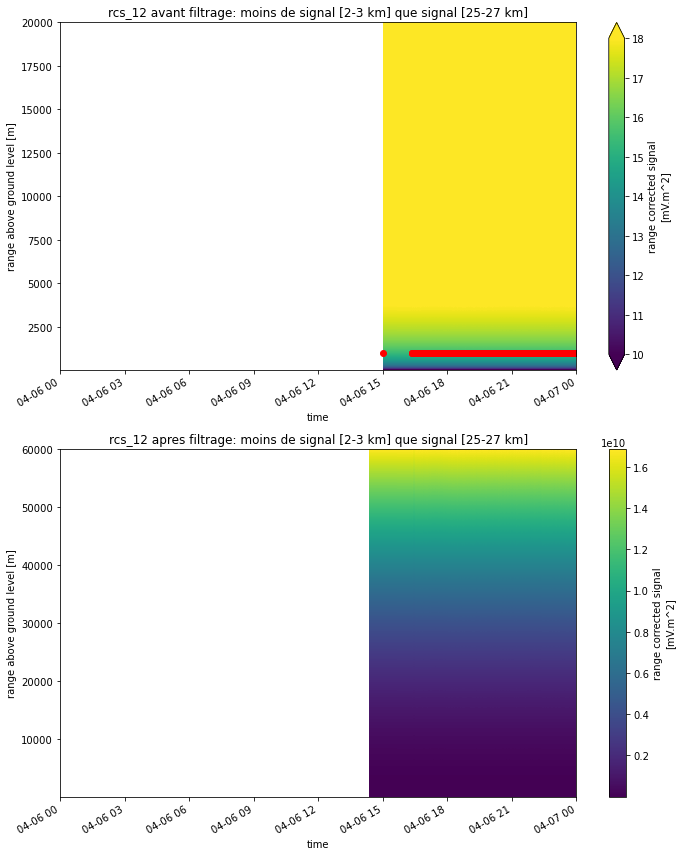

In [185]:
limiteZ = np.where((file['range']<20000))[0]
dateStart = pd.to_datetime(ipralpath.name.split('_')[4])
dateEnd = dateStart + pd.DateOffset(1)
filecorrected = (file['rcs_12']/np.square(file['range']) - file['bckgrd_'+'rcs_12'])*np.square(file['range'])


fg, (ax, ax2)=plt.subplots(figsize=[10,12], nrows=2)
np.log(file['rcs_12']).isel(range=limiteZ).plot(x='time', y='range', vmin=10, vmax=18, ax=ax)
ax.set(title='rcs_12'+' avant filtrage: moins de signal [2-3 km] que signal [25-27 km]')
ax.set_xlim(dateStart, dateEnd)
ax.scatter(file['time'].values[idsmask], np.array([1000]*len(file['time'].values[idsmask])), color='r')
file['rcs_12'].isel(time=idsmask).plot(x='time', y='range',  ax=ax2)
ax2.set(title='rcs_12'+' apres filtrage: moins de signal [2-3 km] que signal [25-27 km]')
ax2.set_xlim(dateStart, dateEnd)
plt.tight_layout()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

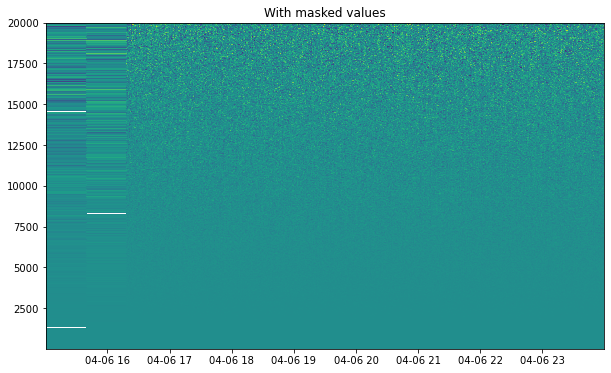

In [176]:
dtmask= np.ma.masked_array(filecorrected.isel(range=limiteZ).values, idsmasks)
fg, axs = plt.subplots(figsize=[10,6])
axs.pcolormesh(file['time'].values, file['range'].isel(range=limiteZ).values, dtmask.T, shading='nearest', cmap='viridis')
axs.set_title('With masked values')
axs.set_xlim(dateStart, dateEnd)

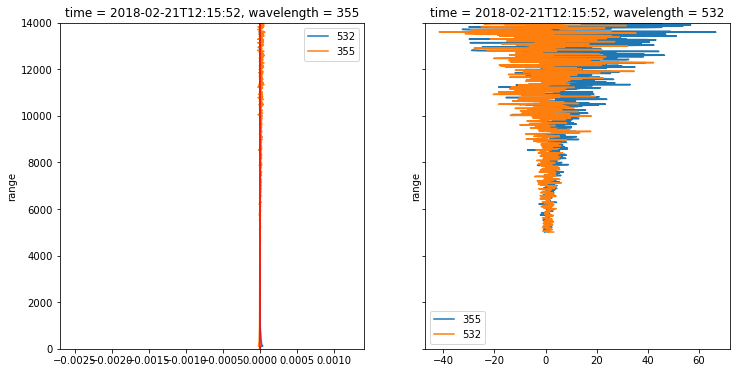

In [99]:
fg, (ax, ax2) = plt.subplots(ncols=2, figsize=[12,6], sharey=True)
residu532[1].isel(time=index_mask[10]).plot(y='range', ax=ax, ylim=(0,14000), label='532')
residu355[1].isel(time=index_mask[10]).plot(y='range', ax=ax, ylim=(0,14000), label='355')
ax.axvline(0, c='r')
ax.legend()
(f['calibrated']/f['simulated']).isel(wavelength=0, range=limite, time=index_mask[10]).plot(y='range', label='355', ax=ax2)
(f['calibrated']/f['simulated']).isel(wavelength=1, range=limite, time=index_mask[10]).plot(y='range', label='532', ax=ax2)
ax2.legend()

## Depolarization 

In [1]:
data = xr.open_dataset('/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20181113_000000_1440.nc')

NameError: name 'xr' is not defined